# DGE analyses for **barley** using `r-sleuth`
In this notebook, DGE-analyses are prepared, with all irrelevant mutants excluded first:
 * 1. **all vs flower** targeting time difference: 0-30 & 70-99 of nonflower tissues **vs** 31-69 flower tissues, mutants excluded:
         - `null = dataset + is_flower`
         - `full = dataset + is_flower[yes-no] + is_reproductive[yes-no]`
 * 2. **all vs flower** targeting tissue difference: 0-30 & 70-99 of nonflower tissues **vs** 31-69 flower tissues, mutants excluded:
         - `null = dataset + is_reproductive[yes-no]`
         - `full = dataset + is_reproductive[yes-no] + is_flower[yes-no]`
 * 3_0. **non_primordium vs primordium** only meristem + flower tissues, targeting time difference, mutants excluded:
     - `null = dataset`
     - `full = dataset + is_primordium`
 * 3. **non_primordium vs primordium** only meristem + flower tissues, targeting time difference, correcting with intermediate_tissue, mutants excluded:
     - `null = intermediate_tissue`
     - `full = intermediate_tissue + is_primordium`
 * 4. **non_primordium vs primordium** using only meristem + flower tissues, targeting tissue difference, correcting with is_primordium, mutants excluded:
     - `null = is_primordium`
     - `full = is_primordium + intermediate_tissue`
 * 5. **floret_dev vs heading stage** targeting time difference (is_heading_vs_floret_development), correcting with tissues using intermediate_tissue, only reproductive, mutants excluded:
     **barley**: using only flower tissues, is_anthesis singular with intermed_tissue, is_anthesis_vs_floret_development
     - `null = instrument`
     - `full = instrument + is_anthesis`
     **wheat**: using only anther+flower tissues - intermed_tissue singular with every possible combination, so better using dataset only
     - `null = dataset`
     - `full = dataset + is_heading`
 * 6. **floret_dev vs heading stage** targeting time difference (is_stem_elongation_vs_floret_development), correcting with tissues using intermediate_tissue, only reproductive, mutants excluded:
     **barley**: : using only flower tissues, is_anthesis singular with intermed_tissue
     - `null = instrument`
     - `full = instrument + is_stem_elongation`  
     **wheat**: : using only anther!! - intermed_tissue singular with every possible combination, so better using dataset only
     - `null = dataset`
     - `full = dataset + is_heading`
 * 7. **flower vs anther** using only flower tissues, targeting tissue difference, correcting with time (Zadok_scale), only reproductive, mutants excluded:
     - `null = instrument + intermediate_age`
     - `full = instrument + intermediate_age + is_anther`
* 8. **flower vs anther** using only flower tissues, targeting tissue difference, correcting with time (Zadok_scale), only reproductive, mutants excluded:
     - `null = instrument + is_anther`
     - `full = instrument + is_anther + intermediate_age`
 * 9. **flower vs anther** flower tissues, wt, all age
     - `null = dataset`
     - `full = dataset + is_anther`

for wheat only     
 * 10. **is_sterile vs wt_anther** using only anther tissues, targeting wt-mut differences, correcting with time (Zadok_scale):
     - `null = instrument + Zadok_scale`
     - `full = instrument + Zadok_scale + is_sterile`
 * 11. **is_sterile vs wt_anther** using only anther tissues, targeting time (Zadok-scale), correcting with wt-mut difference:
     - `null = instrument + is_sterile`
     - `full = instrument + is_sterile + Zadok_scale`
     
## Normalization with reduced + full modells: Variance Stabilization on raw TPM counts
* based on all the exploratory analysis 2(+1) main technical variables are majorly responsible for the clustering of the counts: `dataset`, `library` and `instrument`
* these 3 variables can go to the design matrix: as their numbering and division borders are the same, `dataset` alone covers for all of them, and including all would cause linearity in the model
* if `dataset` causes s
* source: https://pachterlab.github.io/sleuth/about

## Import and prepare data

In [2]:
library(sleuth, warn.conflicts = FALSE)
library(tidyverse, warn.conflicts = FALSE)
library(cowplot, warn.conflicts = FALSE)
library(RColorBrewer, warn.conflicts = FALSE)
library(vsn)
library(pheatmap)
library(shiny)
theme_set(theme_bw())

In [3]:
set.seed(42) # For reproducibility of results

In [61]:
# import metadata
setwd("/home/vanda.marosi/floral_development_thesis_vm/datatables/")
b_metadata <- read.table("barley_final.csv", header = TRUE, sep = ",", stringsAsFactors = FALSE)
b_meta <- select(b_metadata, Run.ID, Dataset, Batch, Cultivar, GM, Zadok_scale, Intermediate_age, High_level_age, Intermediate_tissue, High_level_tissue, Treatment, RNA_extraction, RNA_enrichment, RNA_input..microg., PCR_purification, Growth_condition, Day_night_condition, Temperature_day_night_c, Growth_location, Seq_location, Instrument, Library.layout)
colnames(b_meta) <- c("ID", "dataset", "batch", "cultivar", "gm", "zadok_scale", "intermediate_age", "high_level_age", "intermediate_tissue", "high_level_tissue", "treatment", "rna_extraction", "rna_enrichment", "rna_input", "pcr_purification", "growth_condition", "day_night", "temp", "growth_location", "seq_location", "instrument", "library")
# exclude outliers detected during exploratory analyses: ERR781040, ERR1457187
b_meta <- filter(b_meta, ID != "ERR781040")
b_meta <- filter(b_meta, ID != "ERR1457187")
# exclude outliers detected during first sleuth runs: ERR1457171, ERR1457170, they are from developmental dataset, rachis/grain samples
b_meta <- filter(b_meta, ID != "ERR1457171")
b_meta <- filter(b_meta, ID != "ERR1457170")
# add rownames for deseq2 to identify rows with count-columns
rownames(b_meta) <- b_meta$ID
# select relevant columns
b_meta <- select(b_meta, ID, dataset, gm, zadok_scale, intermediate_age, high_level_age, intermediate_tissue, high_level_tissue, instrument, library)
glimpse(b_meta)

Rows: 236
Columns: 10
$ ID                  <chr> "ERR781039", "ERR781041", "ERR781042", "ERR781043…
$ dataset             <chr> "photoperiod_mutant_preanthesis", "photoperiod_mu…
$ gm                  <chr> "wt", "wt", "mut", "mut", "mut", "wt", "wt", "wt"…
$ zadok_scale         <int> 9, 9, 11, 11, 11, 11, 11, 11, 14, 14, 14, 14, 14,…
$ intermediate_age    <chr> "Germination", "Germination", "Leaf_development",…
$ high_level_age      <chr> "Seedling", "Seedling", "Vegetative", "Vegetative…
$ intermediate_tissue <chr> "apex", "apex", "apex", "apex", "apex", "apex", "…
$ high_level_tissue   <chr> "meristem", "meristem", "meristem", "meristem", "…
$ instrument          <chr> "Illumina HiSeq 2000", "Illumina HiSeq 2000", "Il…
$ library             <chr> "single", "single", "single", "single", "single",…


In [9]:
# load tx2gene object for mRNA mapping information
setwd("/nfs/pgsb/projects/comparative_triticeae/phenotype/flower_development/refsets/hordeum/")
m <- read.delim("barley_tx2gene.tsv",stringsAsFactors=FALSE)
colnames(m) <- c("target_id", "gene")
head(m, 3)
dim(m)

,target_id,gene
,<chr>,<chr>
1,Horvu_MOREX_1H01G000100.1,Horvu_MOREX_1H01G000100
2,Horvu_MOREX_1H01G000200.1,Horvu_MOREX_1H01G000200
3,Horvu_MOREX_1H01G000300.1,Horvu_MOREX_1H01G000300


[1] 49281     2

# 1. contrast: **all vs flower**
* targeting time difference: 0-30 & 70-99 of nonflower tissues **vs** 31-69 flower tissues, mutants excluded:
         - `null = dataset + is_flower`
         - `full = dataset + is_flower[yes-no] + is_reproductive[yes-no]`
## 1.1 Create contrast variables
* **is_flower:** yes = inflorescence, no = all other tissue kinds
* **is_reproductive:** yes = reproductive stage, no = all other stages

In [8]:
# create contrast table
b <- b_meta %>% filter(gm == "wt") %>%
                mutate(is_flower = str_detect(high_level_tissue, "inflorescence")) %>%
                mutate(is_flower = str_replace(is_flower, "TRUE", "yes")) %>%
                mutate(is_flower = str_replace(is_flower, "FALSE", "no"))
b_1 <- b %>% mutate(is_reproductive = str_detect(high_level_age, "Reproductive")) %>%
                     mutate(is_reproductive = str_replace(is_reproductive, "TRUE", "yes")) %>%
                     mutate(is_reproductive = str_replace(is_reproductive, "FALSE", "no")) %>%
                    select(ID, dataset, is_flower, is_reproductive)
b_1$ID <- as.factor(b_1$ID)
b_1$dataset <- as.factor(b_1$dataset)
b_1$is_flower <- as.factor(b_1$is_flower)
b_1$is_reproductive <- as.factor(b_1$is_reproductive)
# inspect full dataset
glimpse(b_1)
tail(b_1, 3)
# inspect ratios of groups
t <- b_1 %>% filter(is_flower == "yes") %>% filter(is_reproductive == "yes")
glimpse(t)
t1 <- b_1 %>% filter(is_flower == "no") %>% filter(is_reproductive == "no")
glimpse(t1)

Rows: 196
Columns: 4
$ ID              <fct> ERR781039, ERR781041, ERR781045, ERR781046, ERR781047…
$ dataset         <fct> photoperiod_mutant_preanthesis, photoperiod_mutant_pr…
$ is_flower       <fct> no, no, no, no, no, no, no, no, no, no, no, no, no, n…
$ is_reproductive <fct> no, no, no, no, no, no, no, no, no, no, no, no, no, n…


,ID,dataset,is_flower,is_reproductive
,<fct>,<fct>,<fct>,<fct>
194,ERR515192,laxatum_mutant,yes,yes
195,ERR515193,laxatum_mutant,yes,yes
196,ERR515194,laxatum_mutant,yes,yes


Rows: 71
Columns: 4
$ ID              <fct> ERR1248084, ERR1248085, ERR1248086, ERR1248087, ERR12…
$ dataset         <fct> drought, drought, drought, drought, drought, drought,…
$ is_flower       <fct> yes, yes, yes, yes, yes, yes, yes, yes, yes, yes, yes…
$ is_reproductive <fct> yes, yes, yes, yes, yes, yes, yes, yes, yes, yes, yes…
Rows: 74
Columns: 4
$ ID              <fct> ERR781039, ERR781041, ERR781045, ERR781046, ERR781047…
$ dataset         <fct> photoperiod_mutant_preanthesis, photoperiod_mutant_pr…
$ is_flower       <fct> no, no, no, no, no, no, no, no, no, no, no, no, no, n…
$ is_reproductive <fct> no, no, no, no, no, no, no, no, no, no, no, no, no, n…


In [10]:
setwd("/nfs/pgsb/projects/comparative_triticeae/phenotype/flower_development/refsets/hordeum/04_Kallisto_allreads_symlinked/")
files <- file.path("..", "04_Kallisto_allreads_symlinked", b_1$ID, "abundance.h5")
names(files) <- paste0(b_1$ID)
head(files)
all(file.exists(files))

ERR781039 
"../04_Kallisto_allreads_symlinked/ERR781039/abundance.h5" 
                                                 ERR781041 
"../04_Kallisto_allreads_symlinked/ERR781041/abundance.h5" 
                                                 ERR781045 
"../04_Kallisto_allreads_symlinked/ERR781045/abundance.h5" 
                                                 ERR781046 
"../04_Kallisto_allreads_symlinked/ERR781046/abundance.h5" 
                                                 ERR781047 
"../04_Kallisto_allreads_symlinked/ERR781047/abundance.h5" 
                                                 ERR781048 
"../04_Kallisto_allreads_symlinked/ERR781048/abundance.h5"

[1] TRUE

In [11]:
s2c_1 <- mutate(b_1, path = files, sample = ID)
head(s2c_1, 3)

,ID,dataset,is_flower,is_reproductive,path,sample
,<fct>,<fct>,<fct>,<fct>,<chr>,<fct>
1,ERR781039,photoperiod_mutant_preanthesis,no,no,../04_Kallisto_allreads_symlinked/ERR781039/abundance.h5,ERR781039
2,ERR781041,photoperiod_mutant_preanthesis,no,no,../04_Kallisto_allreads_symlinked/ERR781041/abundance.h5,ERR781041
3,ERR781045,photoperiod_mutant_preanthesis,no,no,../04_Kallisto_allreads_symlinked/ERR781045/abundance.h5,ERR781045


In [12]:
# construct the sleuth-object
so_1 <- sleuth_prep(sample_to_covariates = s2c_1, 
                  target_mapping = m,
                  extra_bootstrap_summary = TRUE,
                 aggregation_column="gene",
                  gene_mode = TRUE,
                 num_cores=1)

'gene_mode' is TRUE. Sleuth will do counts aggregation at the gene level for downstream normalization, transformation, and modeling steps, as well as for plotting and results.
reading in kallisto results
dropping unused factor levels
....................................................................................................................................................................................................
normalizing est_counts
20302 targets passed the filter
normalizing tpm
merging in metadata
aggregating by column: gene
20302 genes passed the filter
summarizing bootstraps
.................................................
..................................................
..................................................
...............................................


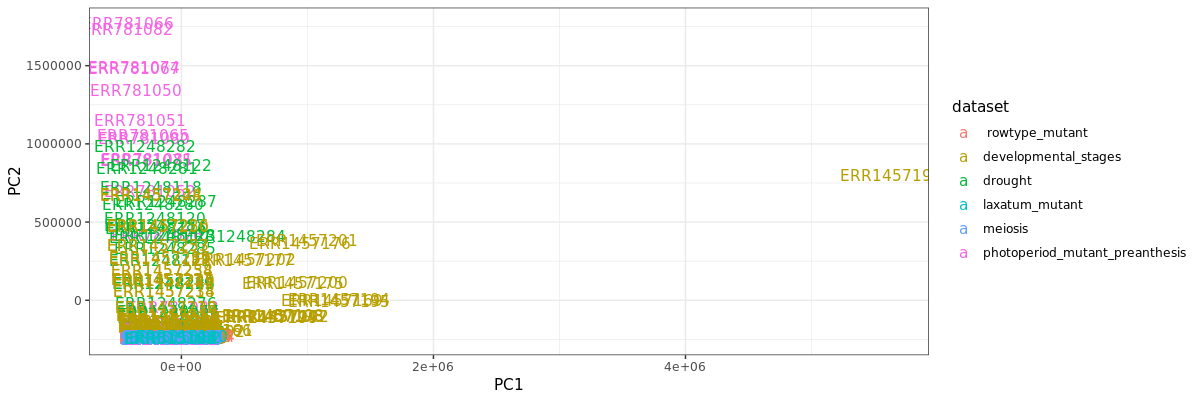

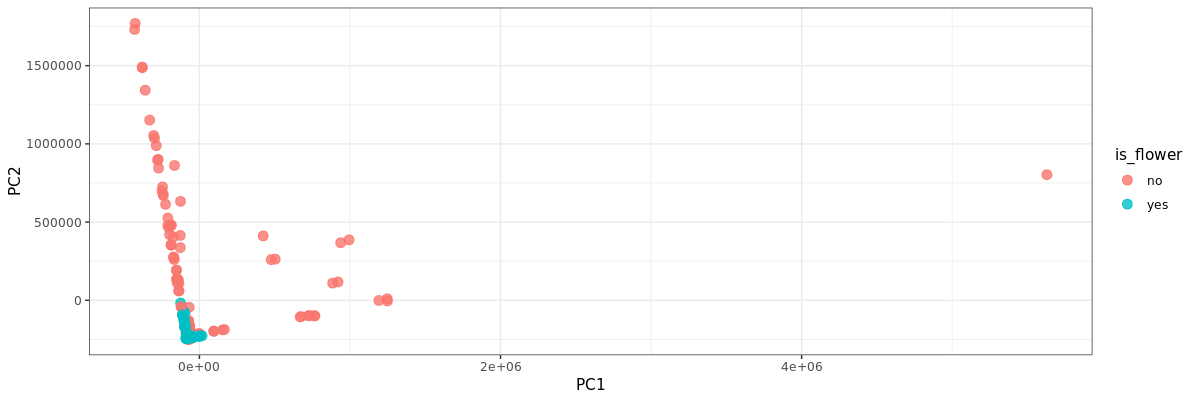

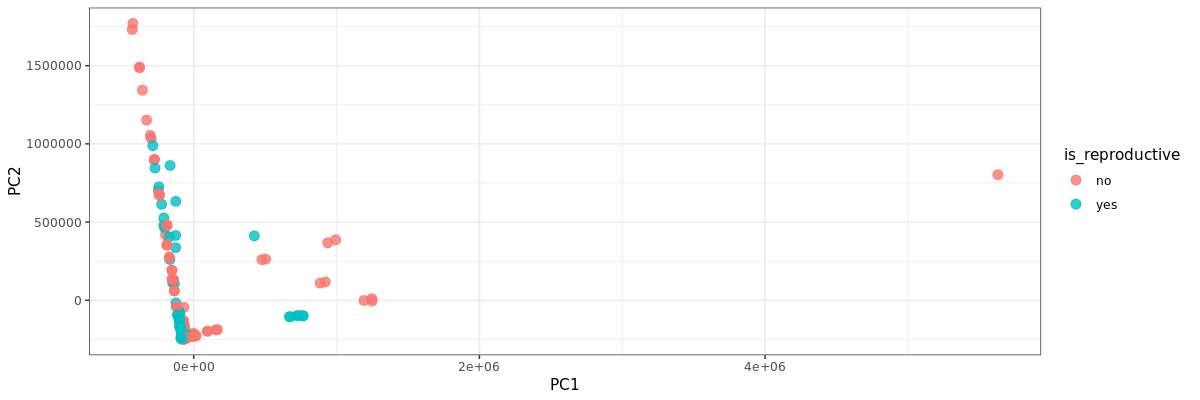

In [13]:
# check for pca
options(repr.plot.width = 12, repr.plot.height = 4, repr.plot.res = 100)
plot_pca(so_1, color_by = 'dataset',text_labels = TRUE,units='scaled_reads_per_base')
plot_pca(so_1, color_by = 'is_flower',text_labels = FALSE,units='scaled_reads_per_base')
plot_pca(so_1, color_by = 'is_reproductive',text_labels = FALSE,units='scaled_reads_per_base')
# two main outliers from developmental stages dataset are rachis samples
# ERR1457171
# ERR1457170
# after excluding them the next new outlier ERR1457196 is a rachis sample from dataset as well

In [16]:
# create models
so_1 <- sleuth_fit(so_1, ~dataset + is_flower + is_reproductive, 'full')
so_1 <- sleuth_fit(so_1, ~dataset + is_flower, 'reduced')

fitting measurement error models
shrinkage estimation
1 NA values were found during variance shrinkage estimation due to mean observation values outside of the range used for the LOESS fit.
The LOESS fit will be repeated using exact computation of the fitted surface to extrapolate the missing values.
These are the target ids with NA values: Horvu_MOREX_5H01G674500
computing variance of betas
fitting measurement error models
shrinkage estimation
1 NA values were found during variance shrinkage estimation due to mean observation values outside of the range used for the LOESS fit.
The LOESS fit will be repeated using exact computation of the fitted surface to extrapolate the missing values.
These are the target ids with NA values: Horvu_MOREX_5H01G674500
computing variance of betas


In [19]:
# perform DGE tests
so_1 <- sleuth_lrt(so_1, 'reduced', 'full')
so_1 <- sleuth_wt(so_1, 'is_reproductiveyes', which_model = "full")

In [20]:
models(so_1)

[  full  ]
formula:  ~dataset + is_flower + is_reproductive 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)
 	datasetdevelopmental_stages
 	datasetdrought
 	datasetlaxatum_mutant
 	datasetmeiosis
 	datasetphotoperiod_mutant_preanthesis
 	is_floweryes
 	is_reproductiveyes
[  reduced  ]
formula:  ~dataset + is_flower 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)
 	datasetdevelopmental_stages
 	datasetdrought
 	datasetlaxatum_mutant
 	datasetmeiosis
 	datasetphotoperiod_mutant_preanthesis
 	is_floweryes


In [24]:
# exctract and inspect results of wald-test
so_wt <- sleuth_results(so_1,'is_reproductiveyes','wt',which_model="full" ,show_all = FALSE,rename_cols=FALSE)
so_wt_sig <- filter(so_wt, qval < 0.05)
nrow(so_wt_sig)
table(so_wt_sig$b>0)

[1] 4223


FALSE  TRUE 
 1982  2241 

In [26]:
# extract and inspect results of lrt
so_lrt <- sleuth_results(so_1, 'reduced:full', test_type = 'lrt',show_all=TRUE)
# join two tables into one
so_all <- na.omit(merge(so_lrt, so_wt, by = "target_id", suffixes = c(".lrt", ".wt")))
head(so_all, 3)

,target_id,pval.lrt,qval.lrt,test_stat,rss,degrees_free,mean_obs.lrt,var_obs.lrt,tech_var,sigma_sq.lrt,⋯,pval.wt,qval.wt,b,se_b,mean_obs.wt,var_obs.wt,sigma_q_sq,sigma_sq.wt,smooth_sigma_sq.wt,smooth_sigma_sq_pmax
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Horvu_MOREX_1H01G000100,0.0003182071,0.00305016,12.960059,21.13448,1,6.854594,0.3098151,0.001154469,0.1106682,⋯,0.0007808644,0.006904664,0.2667788,0.0794105,6.854594,0.3098151,0.001154469,0.1022336,0.1492526,0.1492526
2,Horvu_MOREX_1H01G000200,0.0179097690,0.05483398,5.604954,599.92718,1,2.675636,7.4133009,0.124589737,3.0496281,⋯,0.0190920355,0.078177996,-0.8450215,0.3605457,2.675636,7.4133009,0.124589737,2.9759202,1.2507917,2.9759202
3,Horvu_MOREX_1H01G000300,0.0813491339,0.13149255,3.037739,79.25054,1,5.520472,0.6112949,0.006890828,0.4124242,⋯,0.0845490019,0.221966485,-0.2275178,0.1319035,5.520472,0.6112949,0.006890828,0.4080873,0.2511299,0.4080873


In [27]:
# inspect sig genes
table(so_all$qval.lrt<0.05)
table(so_all$qval.wt<0.05)
table(so_all$qval.lrt<0.05,so_all$qval.wt<0.05)


FALSE  TRUE 
14085  6217 


FALSE  TRUE 
16079  4223 

       
        FALSE  TRUE
  FALSE 14085     0
  TRUE   1994  4223

In [31]:
table1 <- select(so_all, "target_id","test_stat","b","qval.lrt","qval.wt",)
sig1_1 <- filter(table1, qval.lrt <= 0.1)
glimpse(sig1_1)
sig1_05 <- filter(table1, qval.lrt <= 0.05)
glimpse(sig1_05)
sig1_01 <- filter(table1, qval.lrt <= 0.01)
glimpse(sig1_01)
# look at table and few of 0.05
head(sig1_05, 5)

Rows: 10,957
Columns: 5
$ target_id <chr> "Horvu_MOREX_1H01G000100", "Horvu_MOREX_1H01G000200", "Horv…
$ test_stat <dbl> 12.960059, 5.604954, 5.443374, 3.760314, 4.449029, 5.189313…
$ b         <dbl> 0.26677881, -0.84502155, -0.20663871, 0.06818042, 0.1236474…
$ qval.lrt  <dbl> 0.0030501605, 0.0548339813, 0.0578705568, 0.0984398887, 0.0…
$ qval.wt   <dbl> 6.904664e-03, 7.817800e-02, 8.315240e-02, 6.068534e-01, 3.0…
Rows: 6,217
Columns: 5
$ target_id <chr> "Horvu_MOREX_1H01G000100", "Horvu_MOREX_1H01G001100", "Horv…
$ test_stat <dbl> 12.960059, 9.493402, 22.817714, 23.355569, 8.659325, 9.4336…
$ b         <dbl> 0.2667788, 0.2656039, -1.0849344, -1.0262363, 0.2049314, 0.…
$ qval.lrt  <dbl> 3.050160e-03, 1.261291e-02, 4.915040e-05, 3.858530e-05, 1.7…
$ qval.wt   <dbl> 6.904664e-03, 4.880131e-02, 6.969562e-05, 3.785731e-05, 6.1…
Rows: 3,050
Columns: 5
$ target_id <chr> "Horvu_MOREX_1H01G000100", "Horvu_MOREX_1H01G002000", "Horv…
$ test_stat <dbl> 12.96006, 22.81771, 23.35557, 12.02942, 11.

,target_id,test_stat,b,qval.lrt,qval.wt
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,Horvu_MOREX_1H01G000100,12.960059,0.2667788,0.0030501605,6.904664e-03
2,Horvu_MOREX_1H01G001100,9.493402,0.2656039,0.0126129053,4.880131e-02
3,Horvu_MOREX_1H01G002000,22.817714,-1.0849344,0.0000491504,6.969562e-05
4,Horvu_MOREX_1H01G002300,23.355569,-1.0262363,0.0000385853,3.785731e-05
5,Horvu_MOREX_1H01G002600,8.659325,0.2049314,0.0174857145,6.111884e-02


In [332]:
# save 3 sets of DEGsin .csv
setwd("/nfs/pgsb/projects/comparative_triticeae/phenotype/flower_development/refsets/hordeum/")
write.table(sig1_1, file = "deg1_signif0_1.csv", sep = ",", col.names = TRUE)
write.table(sig1_05, file = "deg1_signif0_05.csv", sep = ",", col.names = TRUE)
write.table(sig1_01, file = "deg1_signif0_01.csv", sep = ",", col.names = TRUE)

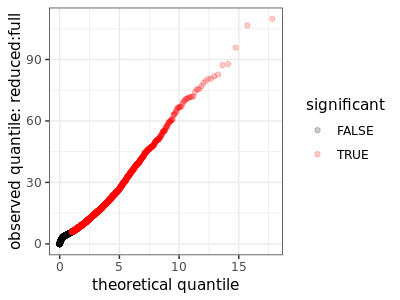

In [35]:
options(repr.plot.width = 4, repr.plot.height = 3, repr.plot.res = 100)
plot_qq(so_1, test = 'reduced:full', test_type = 'lrt', sig_level = 0.05)

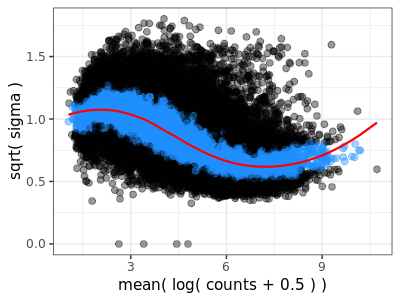

In [36]:
plot_mean_var(so_1,which_model="full")

# 2. contrast: **all vs flower** reverse of the 1. contrast!
* all vs flower targeting tissue difference: 0-30 & 70-99 of nonflower tissues vs 31-69 flower tissues, mutants excluded:
         - `null = dataset + is_reproductive[yes-no]`
         - `full = dataset + is_reproductive[yes-no] + is_flower[yes-no]`
* use same sleuth object, only change designs!

In [37]:
# create models on the same object
so_2 <- sleuth_fit(so_1, ~dataset + is_reproductive + is_flower, 'full')
so_2 <- sleuth_fit(so_1, ~dataset + is_reproductive, 'reduced')

fitting measurement error models
shrinkage estimation
1 NA values were found during variance shrinkage estimation due to mean observation values outside of the range used for the LOESS fit.
The LOESS fit will be repeated using exact computation of the fitted surface to extrapolate the missing values.
These are the target ids with NA values: Horvu_MOREX_5H01G674500
computing variance of betas
fitting measurement error models
shrinkage estimation
computing variance of betas


In [38]:
# perform DGE tests
so_2 <- sleuth_lrt(so_2, 'reduced', 'full')
so_2 <- sleuth_wt(so_2, 'is_floweryes', which_model = "full")

In [39]:
models(so_2)

[  full  ]
formula:  ~dataset + is_flower + is_reproductive 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)
 	datasetdevelopmental_stages
 	datasetdrought
 	datasetlaxatum_mutant
 	datasetmeiosis
 	datasetphotoperiod_mutant_preanthesis
 	is_floweryes
 	is_reproductiveyes
[  reduced  ]
formula:  ~dataset + is_reproductive 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)
 	datasetdevelopmental_stages
 	datasetdrought
 	datasetlaxatum_mutant
 	datasetmeiosis
 	datasetphotoperiod_mutant_preanthesis
 	is_reproductiveyes


In [40]:
# exctract and inspect results of wald-test
so_wt2 <- sleuth_results(so_2,'is_floweryes','wt',which_model="full" ,show_all = FALSE,rename_cols=FALSE)
so_wt_sig2 <- filter(so_wt2, qval < 0.05)
nrow(so_wt_sig2)
table(so_wt_sig2$b>0)

[1] 11051


FALSE  TRUE 
 5064  5987 

In [41]:
# extract and inspect results of lrt
so_lrt2 <- sleuth_results(so_2, 'reduced:full', test_type = 'lrt',show_all=TRUE)
# join two tables into one
so_all2 <- na.omit(merge(so_lrt2, so_wt, by = "target_id", suffixes = c(".lrt", ".wt")))
head(so_all2, 3)

,target_id,pval.lrt,qval.lrt,test_stat,rss,degrees_free,mean_obs.lrt,var_obs.lrt,tech_var,sigma_sq.lrt,⋯,pval.wt,qval.wt,b,se_b,mean_obs.wt,var_obs.wt,sigma_q_sq,sigma_sq.wt,smooth_sigma_sq.wt,smooth_sigma_sq_pmax
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Horvu_MOREX_1H01G000100,1.416744e-07,8.043273e-07,27.69984,22.99803,1,6.854594,0.3098151,0.001154469,0.1205282,⋯,0.0007808644,0.006904664,0.2667788,0.0794105,6.854594,0.3098151,0.001154469,0.1022336,0.1492526,0.1492526
2,Horvu_MOREX_1H01G000200,2.348445e-16,8.590653e-15,67.28599,821.80853,1,2.675636,7.4133009,0.124589737,4.2236036,⋯,0.0190920355,0.078177996,-0.8450215,0.3605457,2.675636,7.4133009,0.124589737,2.9759202,1.2507917,2.9759202
3,Horvu_MOREX_1H01G000300,3.179780e-04,6.290771e-04,12.96141,83.36639,1,5.520472,0.6112949,0.006890828,0.4342012,⋯,0.0845490019,0.221966485,-0.2275178,0.1319035,5.520472,0.6112949,0.006890828,0.4080873,0.2511299,0.4080873


In [42]:
# inspect sig genes
table(so_all2$qval.lrt<0.05)
table(so_all2$qval.wt<0.05)
table(so_all2$qval.lrt<0.05,so_all2$qval.wt<0.05)


FALSE  TRUE 
 3234 17068 


FALSE  TRUE 
16079  4223 

       
        FALSE  TRUE
  FALSE  2296   938
  TRUE  13783  3285

In [43]:
table2 <- select(so_all2, "target_id","test_stat","b","qval.lrt","qval.wt",)
sig2_1 <- filter(table2, qval.lrt <= 0.1)
glimpse(sig2_1)
sig2_05 <- filter(table2, qval.lrt <= 0.05)
glimpse(sig2_05)
sig2_01 <- filter(table2, qval.lrt <= 0.01)
glimpse(sig2_01)
# look at table and few of 0.05
head(sig2_05, 5)

Rows: 17,761
Columns: 5
$ target_id <chr> "Horvu_MOREX_1H01G000100", "Horvu_MOREX_1H01G000200", "Horv…
$ test_stat <dbl> 27.699840, 67.285989, 12.961408, 37.259174, 8.771375, 12.08…
$ b         <dbl> 0.266778805, -0.845021546, -0.227517843, -0.206638708, 0.01…
$ qval.lrt  <dbl> 8.043273e-07, 8.590653e-15, 6.290771e-04, 9.340663e-09, 4.4…
$ qval.wt   <dbl> 6.904664e-03, 7.817800e-02, 2.219665e-01, 8.315240e-02, 9.1…
Rows: 17,068
Columns: 5
$ target_id <chr> "Horvu_MOREX_1H01G000100", "Horvu_MOREX_1H01G000200", "Horv…
$ test_stat <dbl> 27.699840, 67.285989, 12.961408, 37.259174, 8.771375, 12.08…
$ b         <dbl> 0.266778805, -0.845021546, -0.227517843, -0.206638708, 0.01…
$ qval.lrt  <dbl> 8.043273e-07, 8.590653e-15, 6.290771e-04, 9.340663e-09, 4.4…
$ qval.wt   <dbl> 6.904664e-03, 7.817800e-02, 2.219665e-01, 8.315240e-02, 9.1…
Rows: 15,169
Columns: 5
$ target_id <chr> "Horvu_MOREX_1H01G000100", "Horvu_MOREX_1H01G000200", "Horv…
$ test_stat <dbl> 27.699840, 67.285989, 12.961408, 37.25917

,target_id,test_stat,b,qval.lrt,qval.wt
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,Horvu_MOREX_1H01G000100,27.699840,0.26677881,8.043273e-07,0.006904664
2,Horvu_MOREX_1H01G000200,67.285989,-0.84502155,8.590653e-15,0.078177996
3,Horvu_MOREX_1H01G000300,12.961408,-0.22751784,6.290771e-04,0.221966485
4,Horvu_MOREX_1H01G000400,37.259174,-0.20663871,9.340663e-09,0.083152403
5,Horvu_MOREX_1H01G000500,8.771375,0.01650858,4.434192e-03,0.911969720


In [333]:
# save 3 sets of DEGsin .csv
setwd("/nfs/pgsb/projects/comparative_triticeae/phenotype/flower_development/refsets/hordeum/")
write.table(sig2_1, file = "deg2_signif0_1.csv", sep = ",", col.names = TRUE)
write.table(sig2_05, file = "deg2_signif0_05.csv", sep = ",", col.names = TRUE)
write.table(sig2_01, file = "deg2_signif0_01.csv", sep = ",", col.names = TRUE)

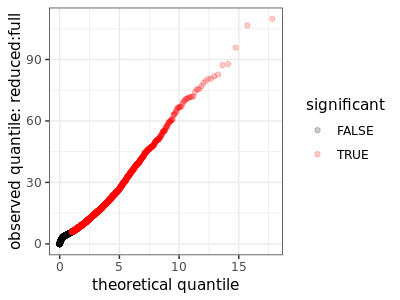

In [35]:
options(repr.plot.width = 4, repr.plot.height = 3, repr.plot.res = 100)
plot_qq(so_2, test = 'reduced:full', test_type = 'lrt', sig_level = 0.05)

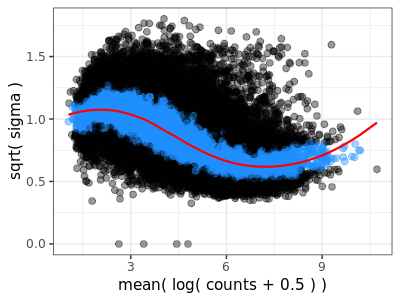

In [36]:
plot_mean_var(so_2, which_model="full")

# 3_0. Contrast: **non_primordium vs primordium** 
* using only meristem + flower tissues, 
* targeting time difference, 
* correcting with intermediate_tissue, 
* mutants excluded
* dataset caused singularity!
     - `null = dataset`
     - `full = dataset + is_primordium`
* Create contrast variables:
     - **is_primordium:** yes = 13-30Z flower&primordium tissues, no = 31-69Z flower&primordium tissues

In [285]:
# here leave only wt samples and flower+meristem tissues in the analysis (this will be repeated with including only inflorescence)
is_primordium_tissue <- b_meta %>% filter(gm == "wt") %>%
                                    filter(high_level_tissue == "inflorescence" |
                                            high_level_tissue == "meristem") %>% select(ID, dataset, library, intermediate_tissue, zadok_scale) 
# here we select samples that are in primordium stage
is_primordium_yes <- is_primordium_tissue %>% filter(zadok_scale <= 30 & zadok_scale >= 13) %>% 
                                              add_column(is_primordium = "yes") %>% 
                                              select(ID, library, intermediate_tissue, is_primordium, dataset)
# here we select samples that are not in primordium stage, but are in flowering stage
is_primordium_no <- is_primordium_tissue %>% filter(zadok_scale >= 31 & zadok_scale <= 69) %>% 
                                             add_column(is_primordium = "no") %>% 
                                             select(ID, library, intermediate_tissue, is_primordium, dataset)
# here we join tables of primordium stage or not into one
b_30 <- bind_rows(is_primordium_yes, is_primordium_no)
b_30$ID <- as.factor(b_30$ID)
b_30$library <- as.factor(b_30$library)
b_30$dataset <- as.factor(b_30$dataset)
b_30$is_primordium <- as.factor(b_30$is_primordium)
# inspect ratios of groups
glimpse(is_primordium_tissue) # flower & meristem tissues
glimpse(is_primordium_yes)
glimpse(is_primordium_no)
# inspect full dataset
glimpse(b_30)
tail(b_30, 3)

Rows: 110
Columns: 5
$ ID                  <chr> "ERR781039", "ERR781041", "ERR781045", "ERR781046…
$ dataset             <chr> "photoperiod_mutant_preanthesis", "photoperiod_mu…
$ library             <chr> "single", "single", "single", "single", "single",…
$ intermediate_tissue <chr> "apex", "apex", "apex", "apex", "apex", "apex", "…
$ zadok_scale         <int> 9, 9, 11, 11, 11, 14, 14, 14, 14, 14, 11, 11, 11,…
Rows: 31
Columns: 5
$ ID                  <chr> "ERR781048", "ERR781049", "ERR781056", "ERR781057…
$ library             <chr> "single", "single", "single", "single", "single",…
$ intermediate_tissue <chr> "apex", "apex", "apex", "apex", "apex", "apex", "…
$ is_primordium       <chr> "yes", "yes", "yes", "yes", "yes", "yes", "yes", …
$ dataset             <chr> "photoperiod_mutant_preanthesis", "photoperiod_mu…
Rows: 71
Columns: 5
$ ID                  <chr> "ERR1248084", "ERR1248085", "ERR1248086", "ERR124…
$ library             <chr> "paired", "paired", "paired", "paired", "p

,ID,library,intermediate_tissue,is_primordium,dataset
,<fct>,<fct>,<chr>,<fct>,<fct>
100,ERR515192,paired,spike,no,laxatum_mutant
101,ERR515193,paired,spike,no,laxatum_mutant
102,ERR515194,paired,spike,no,laxatum_mutant


In [286]:
setwd("/nfs/pgsb/projects/comparative_triticeae/phenotype/flower_development/refsets/hordeum/04_Kallisto_allreads_symlinked/")
files <- file.path("..", "04_Kallisto_allreads_symlinked", b_30$ID, "abundance.h5")
names(files) <- paste0(b_30$ID)
head(files)
all(file.exists(files))

ERR781048 
"../04_Kallisto_allreads_symlinked/ERR781048/abundance.h5" 
                                                 ERR781049 
"../04_Kallisto_allreads_symlinked/ERR781049/abundance.h5" 
                                                 ERR781056 
"../04_Kallisto_allreads_symlinked/ERR781056/abundance.h5" 
                                                 ERR781057 
"../04_Kallisto_allreads_symlinked/ERR781057/abundance.h5" 
                                                 ERR781058 
"../04_Kallisto_allreads_symlinked/ERR781058/abundance.h5" 
                                                 ERR781071 
"../04_Kallisto_allreads_symlinked/ERR781071/abundance.h5"

[1] TRUE

In [287]:
s2c_30 <- mutate(b_30, path = files, sample = ID)
head(s2c_30, 3)

,ID,library,intermediate_tissue,is_primordium,dataset,path,sample
,<fct>,<fct>,<chr>,<fct>,<fct>,<chr>,<fct>
1,ERR781048,single,apex,yes,photoperiod_mutant_preanthesis,../04_Kallisto_allreads_symlinked/ERR781048/abundance.h5,ERR781048
2,ERR781049,single,apex,yes,photoperiod_mutant_preanthesis,../04_Kallisto_allreads_symlinked/ERR781049/abundance.h5,ERR781049
3,ERR781056,single,apex,yes,photoperiod_mutant_preanthesis,../04_Kallisto_allreads_symlinked/ERR781056/abundance.h5,ERR781056


In [289]:
# construct the sleuth-object
so_30 <- sleuth_prep(sample_to_covariates = s2c_30, 
                  target_mapping = m,
                  extra_bootstrap_summary = TRUE,
                 aggregation_column="gene",
                  gene_mode = TRUE,
                 num_cores=1)

'gene_mode' is TRUE. Sleuth will do counts aggregation at the gene level for downstream normalization, transformation, and modeling steps, as well as for plotting and results.
reading in kallisto results
dropping unused factor levels
......................................................................................................
normalizing est_counts
20821 targets passed the filter
normalizing tpm
merging in metadata
aggregating by column: gene
20821 genes passed the filter
summarizing bootstraps
.................................................
..................................................
...


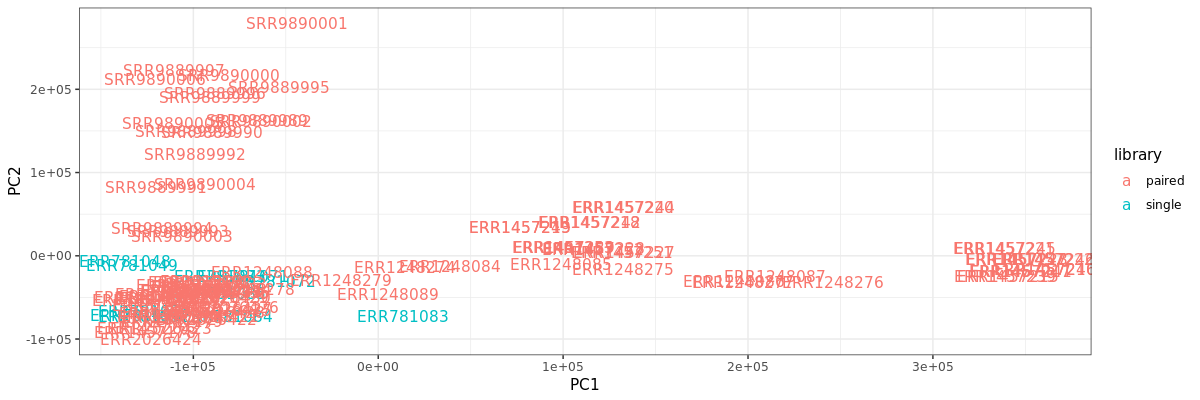

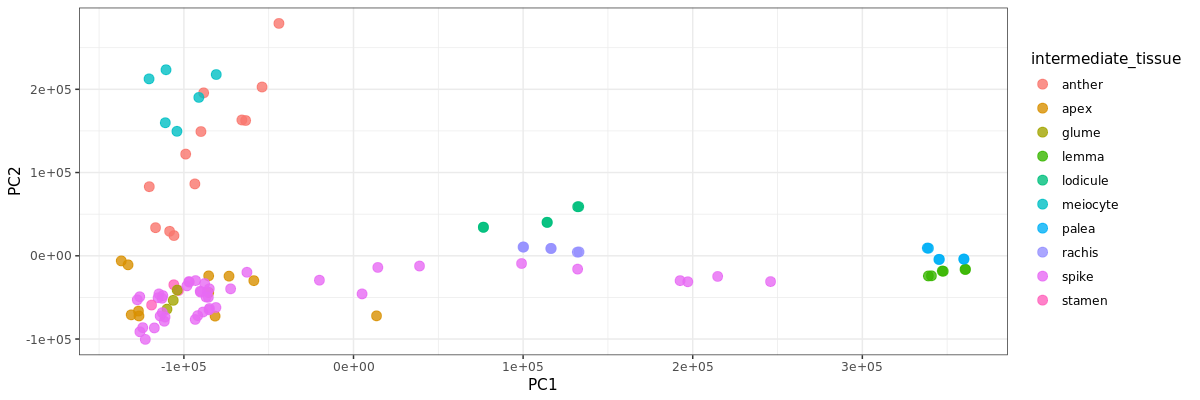

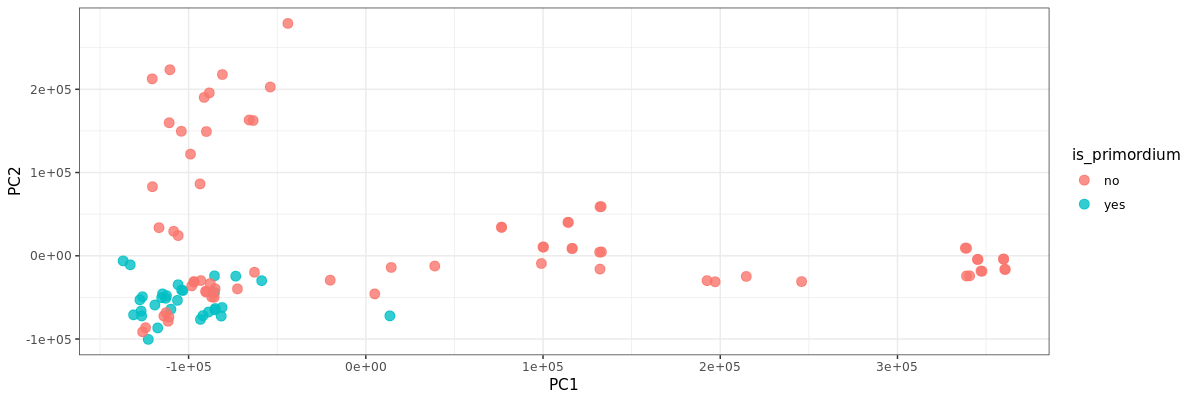

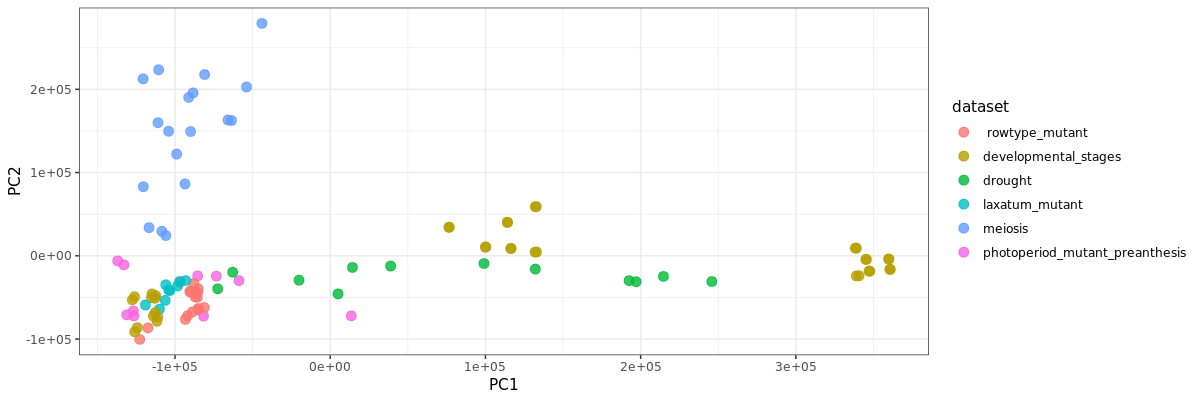

In [290]:
# check for pca
options(repr.plot.width = 12, repr.plot.height = 4, repr.plot.res = 100)
plot_pca(so_30, color_by = 'library',text_labels = TRUE,units='scaled_reads_per_base')
plot_pca(so_30, color_by = 'intermediate_tissue',text_labels = FALSE,units='scaled_reads_per_base')
plot_pca(so_30, color_by = 'is_primordium',text_labels = FALSE,units='scaled_reads_per_base')
plot_pca(so_30, color_by = 'dataset',text_labels = FALSE,units='scaled_reads_per_base')
# two main outliers from developmental stages dataset are rachis samples
# ERR1457171
# ERR1457170
# after excluding them the next new outlier ERR1457196 is a rachis sample from dataset as well

In [298]:
# create models
so_30 <- sleuth_fit(so_30, ~dataset + is_primordium, 'full')
so_30 <- sleuth_fit(so_30, ~dataset, 'reduced')

ERROR: Error in solve.default(t(X) %*% X): system is computationally singular: reciprocal condition number = 7.818e-21


In [292]:
# perform DGE tests
so_30 <- sleuth_lrt(so_30, 'reduced', 'full')
so_30 <- sleuth_wt(so_30, 'is_primordiumyes', which_model = "full")

In [293]:
models(so_30)

[  full  ]
formula:  ~dataset + is_primordium 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)
 	datasetdevelopmental_stages
 	datasetdrought
 	datasetlaxatum_mutant
 	datasetmeiosis
 	datasetphotoperiod_mutant_preanthesis
 	is_primordiumyes
[  reduced  ]
formula:  ~dataset 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)
 	datasetdevelopmental_stages
 	datasetdrought
 	datasetlaxatum_mutant
 	datasetmeiosis
 	datasetphotoperiod_mutant_preanthesis


In [294]:
# exctract and inspect results of wald-test
so_wt30 <- sleuth_results(so_30,'is_primordiumyes','wt',which_model="full" ,show_all = FALSE,rename_cols=FALSE)
so_wt_sig30 <- filter(so_wt30, qval < 0.05)
nrow(so_wt_sig30)
table(so_wt_sig30$b>0)

[1] 8691


FALSE  TRUE 
 4768  3923 

In [295]:
# extract and inspect results of lrt
so_lrt30 <- sleuth_results(so_30, 'reduced:full', test_type = 'lrt',show_all=TRUE)
# join two tables into one
so_all30 <- na.omit(merge(so_lrt30, so_wt30, by = "target_id", suffixes = c(".lrt", ".wt")))
head(so_all30, 3)

,target_id,pval.lrt,qval.lrt,test_stat,rss,degrees_free,mean_obs.lrt,var_obs.lrt,tech_var,sigma_sq.lrt,⋯,pval.wt,qval.wt,b,se_b,mean_obs.wt,var_obs.wt,sigma_q_sq,sigma_sq.wt,smooth_sigma_sq.wt,smooth_sigma_sq_pmax
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Horvu_MOREX_1H01G000100,0.001001878,0.003938719,10.82409193,8.910775,1,7.057235,0.2964395,0.0008531772,0.0919674,⋯,0.00113995,0.004962346,-0.28859732,0.0887038,7.057235,0.2964395,0.0008531772,0.08330054,0.08569884,0.08569884
2,Horvu_MOREX_1H01G000300,0.066728606,0.083140226,3.36171342,10.622322,1,5.629061,0.1294272,0.0044887557,0.1061604,⋯,0.37878961,0.498185744,-0.10346787,0.1175599,5.629061,0.1294272,0.0044887557,0.10608556,0.14753498,0.14753498
3,Horvu_MOREX_1H01G000400,0.832984527,0.854152713,0.04446842,12.715816,1,6.719473,0.2240490,0.0014985755,0.1309578,⋯,0.74605554,0.820358374,-0.03570354,0.1102489,6.719473,0.2240490,0.0014985755,0.13220452,0.09270054,0.13220452


In [296]:
# inspect sig genes
table(so_all30$qval.lrt<0.05)
table(so_all30$qval.wt<0.05)
table(so_all30$qval.lrt<0.05,so_all30$qval.wt<0.05)


FALSE  TRUE 
 5431 15390 


FALSE  TRUE 
12130  8691 

       
        FALSE TRUE
  FALSE  5431    0
  TRUE   6699 8691

In [297]:
table30 <- select(so_all30, "target_id","test_stat","b","qval.lrt","qval.wt",)
sig30_1 <- filter(table30, qval.lrt <= 0.1)
glimpse(sig30_1)
sig30_05 <- filter(table30, qval.lrt <= 0.05)
glimpse(sig30_05)
sig30_01 <- filter(table30, qval.lrt <= 0.01)
glimpse(sig30_01)
# look at table and few of 0.05
head(sig30_05, 5)

Rows: 17,069
Columns: 5
$ target_id <chr> "Horvu_MOREX_1H01G000100", "Horvu_MOREX_1H01G000300", "Horv…
$ test_stat <dbl> 10.824092, 3.361713, 5.973414, 8.278962, 4.929474, 7.306340…
$ b         <dbl> -0.288597323, -0.103467873, -0.062047143, -0.154489123, -0.…
$ qval.lrt  <dbl> 3.938719e-03, 8.314023e-02, 2.498647e-02, 1.067044e-02, 3.8…
$ qval.wt   <dbl> 4.962346e-03, 4.981857e-01, 5.984888e-01, 1.547250e-01, 9.3…
Rows: 15,390
Columns: 5
$ target_id <chr> "Horvu_MOREX_1H01G000100", "Horvu_MOREX_1H01G000600", "Horv…
$ test_stat <dbl> 10.824092, 5.973414, 8.278962, 4.929474, 7.306340, 4.633555…
$ b         <dbl> -0.288597323, -0.062047143, -0.154489123, -0.011731908, 0.8…
$ qval.lrt  <dbl> 3.938719e-03, 2.498647e-02, 1.067044e-02, 3.832634e-02, 1.5…
$ qval.wt   <dbl> 4.962346e-03, 5.984888e-01, 1.547250e-01, 9.311030e-01, 2.2…
Rows: 7,610
Columns: 5
$ target_id <chr> "Horvu_MOREX_1H01G000100", "Horvu_MOREX_1H01G002600", "Horv…
$ test_stat <dbl> 10.824092, 9.500953, 15.587209, 14.801549,

,target_id,test_stat,b,qval.lrt,qval.wt
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,Horvu_MOREX_1H01G000100,10.824092,-0.28859732,0.003938719,0.004962346
2,Horvu_MOREX_1H01G000600,5.973414,-0.06204714,0.024986469,0.598488835
3,Horvu_MOREX_1H01G000700,8.278962,-0.15448912,0.010670443,0.154724968
4,Horvu_MOREX_1H01G000800,4.929474,-0.01173191,0.038326341,0.931102998
5,Horvu_MOREX_1H01G000900,7.306340,0.81272476,0.015436808,0.022202580


In [336]:
# save 3 sets of DEGsin .csv
setwd("/nfs/pgsb/projects/comparative_triticeae/phenotype/flower_development/refsets/hordeum/")
write.table(sig30_1, file = "deg30_signif0_1.csv", sep = ",", col.names = TRUE)
write.table(sig30_05, file = "deg30_signif0_05.csv", sep = ",", col.names = TRUE)
write.table(sig30_01, file = "deg30_signif0_01.csv", sep = ",", col.names = TRUE)

# 3. Contrast: **non_primordium vs primordium** 
* using only meristem + flower tissues, 
* targeting time difference, 
* correcting with intermediate_tissue, 
* mutants excluded
* dataset caused singularity!
     - `null = intermediate_tissue`
     - `full = intermediate_tissue + is_primordium`
* Create contrast variables:
     - **is_primordium:** yes = 13-30Z flower&primordium tissues, no = 31-69Z flower&primordium tissues

In [62]:
# here leave only wt samples and flower+meristem tissues in the analysis (this will be repeated with including only inflorescence)
is_primordium_tissue <- b_meta %>% filter(gm == "wt") %>%
                                    filter(high_level_tissue == "inflorescence" |
                                            high_level_tissue == "meristem") %>% select(ID, library, intermediate_tissue, zadok_scale) 
# here we select samples that are in primordium stage
is_primordium_yes <- is_primordium_tissue %>% filter(zadok_scale <= 30 & zadok_scale >= 13) %>% 
                                              add_column(is_primordium = "yes") %>% 
                                              select(ID, library, intermediate_tissue, is_primordium)
# here we select samples that are not in primordium stage, but are in flowering stage
is_primordium_no <- is_primordium_tissue %>% filter(zadok_scale >= 31 & zadok_scale <= 69) %>% 
                                             add_column(is_primordium = "no") %>% 
                                             select(ID, library, intermediate_tissue, is_primordium)
# here we join tables of primordium stage or not into one
b_3 <- bind_rows(is_primordium_yes, is_primordium_no)
b_3$ID <- as.factor(b_3$ID)
b_3$library <- as.factor(b_3$library)
b_3$is_primordium <- as.factor(b_3$is_primordium)
# inspect ratios of groups
glimpse(is_primordium_tissue) # flower & meristem tissues
glimpse(is_primordium_yes)
glimpse(is_primordium_no)
# inspect full dataset
glimpse(b_3)
tail(b_3, 3)

Rows: 110
Columns: 4
$ ID                  <chr> "ERR781039", "ERR781041", "ERR781045", "ERR781046…
$ library             <chr> "single", "single", "single", "single", "single",…
$ intermediate_tissue <chr> "apex", "apex", "apex", "apex", "apex", "apex", "…
$ zadok_scale         <int> 9, 9, 11, 11, 11, 14, 14, 14, 14, 14, 11, 11, 11,…
Rows: 31
Columns: 4
$ ID                  <chr> "ERR781048", "ERR781049", "ERR781056", "ERR781057…
$ library             <chr> "single", "single", "single", "single", "single",…
$ intermediate_tissue <chr> "apex", "apex", "apex", "apex", "apex", "apex", "…
$ is_primordium       <chr> "yes", "yes", "yes", "yes", "yes", "yes", "yes", …
Rows: 71
Columns: 4
$ ID                  <chr> "ERR1248084", "ERR1248085", "ERR1248086", "ERR124…
$ library             <chr> "paired", "paired", "paired", "paired", "paired",…
$ intermediate_tissue <chr> "spike", "spike", "spike", "spike", "spike", "spi…
$ is_primordium       <chr> "no", "no", "no", "no", "no", "no", "no", 

,ID,library,intermediate_tissue,is_primordium
,<fct>,<fct>,<chr>,<fct>
100,ERR515192,paired,spike,no
101,ERR515193,paired,spike,no
102,ERR515194,paired,spike,no


In [63]:
setwd("/nfs/pgsb/projects/comparative_triticeae/phenotype/flower_development/refsets/hordeum/04_Kallisto_allreads_symlinked/")
files <- file.path("..", "04_Kallisto_allreads_symlinked", b_3$ID, "abundance.h5")
names(files) <- paste0(b_3$ID)
head(files)
all(file.exists(files))

ERR781048 
"../04_Kallisto_allreads_symlinked/ERR781048/abundance.h5" 
                                                 ERR781049 
"../04_Kallisto_allreads_symlinked/ERR781049/abundance.h5" 
                                                 ERR781056 
"../04_Kallisto_allreads_symlinked/ERR781056/abundance.h5" 
                                                 ERR781057 
"../04_Kallisto_allreads_symlinked/ERR781057/abundance.h5" 
                                                 ERR781058 
"../04_Kallisto_allreads_symlinked/ERR781058/abundance.h5" 
                                                 ERR781071 
"../04_Kallisto_allreads_symlinked/ERR781071/abundance.h5"

[1] TRUE

In [64]:
s2c_3 <- mutate(b_3, path = files, sample = ID)
head(s2c_3, 3)

,ID,library,intermediate_tissue,is_primordium,path,sample
,<fct>,<fct>,<chr>,<fct>,<chr>,<fct>
1,ERR781048,single,apex,yes,../04_Kallisto_allreads_symlinked/ERR781048/abundance.h5,ERR781048
2,ERR781049,single,apex,yes,../04_Kallisto_allreads_symlinked/ERR781049/abundance.h5,ERR781049
3,ERR781056,single,apex,yes,../04_Kallisto_allreads_symlinked/ERR781056/abundance.h5,ERR781056


In [65]:
# construct the sleuth-object
so_3 <- sleuth_prep(sample_to_covariates = s2c_3, 
                  target_mapping = m,
                  extra_bootstrap_summary = TRUE,
                 aggregation_column="gene",
                  gene_mode = TRUE,
                 num_cores=1)

'gene_mode' is TRUE. Sleuth will do counts aggregation at the gene level for downstream normalization, transformation, and modeling steps, as well as for plotting and results.
reading in kallisto results
dropping unused factor levels
......................................................................................................
normalizing est_counts
20821 targets passed the filter
normalizing tpm
merging in metadata
aggregating by column: gene
20821 genes passed the filter
summarizing bootstraps
.................................................
..................................................
...


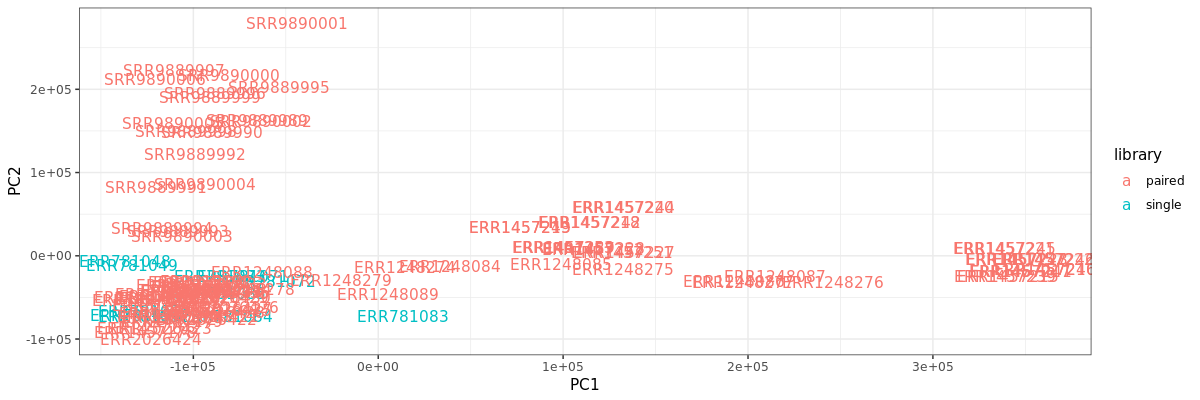

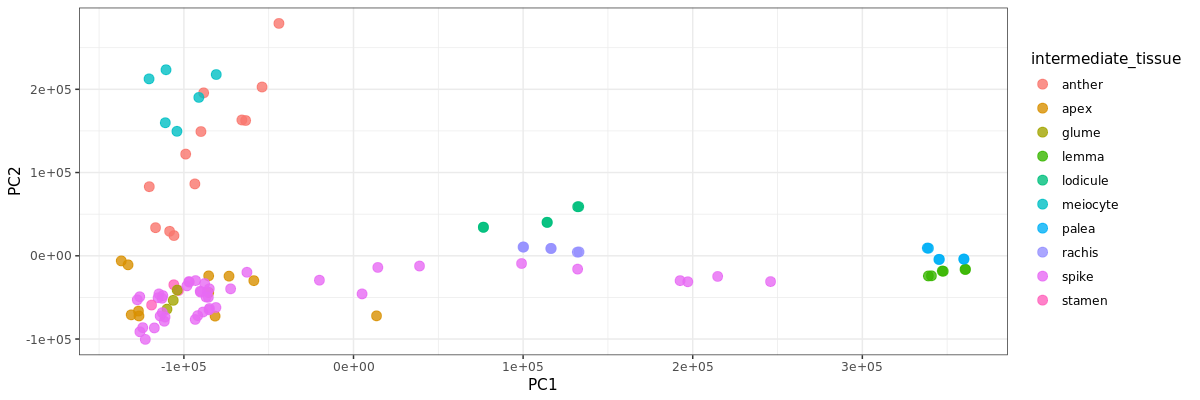

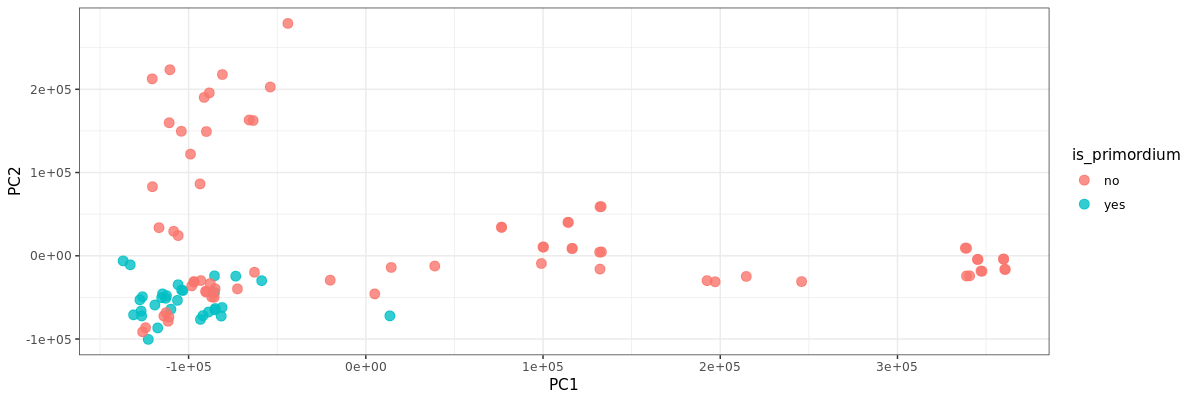

In [67]:
# check for pca
options(repr.plot.width = 12, repr.plot.height = 4, repr.plot.res = 100)
plot_pca(so_3, color_by = 'library',text_labels = TRUE,units='scaled_reads_per_base')
plot_pca(so_3, color_by = 'intermediate_tissue',text_labels = FALSE,units='scaled_reads_per_base')
plot_pca(so_3, color_by = 'is_primordium',text_labels = FALSE,units='scaled_reads_per_base')
# two main outliers from developmental stages dataset are rachis samples
# ERR1457171
# ERR1457170
# after excluding them the next new outlier ERR1457196 is a rachis sample from dataset as well

In [83]:
# create models
so_3 <- sleuth_fit(so_3, ~intermediate_tissue + is_primordium, 'full')
so_3 <- sleuth_fit(so_3, ~intermediate_tissue, 'reduced')

fitting measurement error models
shrinkage estimation
computing variance of betas
fitting measurement error models
shrinkage estimation
computing variance of betas


In [84]:
# perform DGE tests
so_3 <- sleuth_lrt(so_3, 'reduced', 'full')
so_3 <- sleuth_wt(so_3, 'is_primordiumyes', which_model = "full")

In [85]:
models(so_3)

[  full  ]
formula:  ~intermediate_tissue + is_primordium 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)
 	intermediate_tissueapex
 	intermediate_tissueglume
 	intermediate_tissuelemma
 	intermediate_tissuelodicule
 	intermediate_tissuemeiocyte
 	intermediate_tissuepalea
 	intermediate_tissuerachis
 	intermediate_tissuespike
 	intermediate_tissuestamen
 	is_primordiumyes
[  reduced  ]
formula:  ~intermediate_tissue 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)
 	intermediate_tissueapex
 	intermediate_tissueglume
 	intermediate_tissuelemma
 	intermediate_tissuelodicule
 	intermediate_tissuemeiocyte
 	intermediate_tissuepalea
 	intermediate_tissuerachis
 	intermediate_tissuespike
 	intermediate_tissuestamen


In [86]:
# exctract and inspect results of wald-test
so_wt3 <- sleuth_results(so_3,'is_primordiumyes','wt',which_model="full" ,show_all = FALSE,rename_cols=FALSE)
so_wt_sig3 <- filter(so_wt3, qval < 0.05)
nrow(so_wt_sig3)
table(so_wt_sig3$b>0)

[1] 8851


FALSE  TRUE 
 4935  3916 

In [87]:
# extract and inspect results of lrt
so_lrt3 <- sleuth_results(so_3, 'reduced:full', test_type = 'lrt',show_all=TRUE)
# join two tables into one
so_all3 <- na.omit(merge(so_lrt3, so_wt3, by = "target_id", suffixes = c(".lrt", ".wt")))
head(so_all3, 3)

,target_id,pval.lrt,qval.lrt,test_stat,rss,degrees_free,mean_obs.lrt,var_obs.lrt,tech_var,sigma_sq.lrt,⋯,pval.wt,qval.wt,b,se_b,mean_obs.wt,var_obs.wt,sigma_q_sq,sigma_sq.wt,smooth_sigma_sq.wt,smooth_sigma_sq_pmax
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Horvu_MOREX_1H01G000100,0.091378709,0.10949563,2.849916,4.462542,1,7.057235,0.2964395,0.0008531772,0.04765271,⋯,0.3941829,0.5093310,0.06526302,0.07659473,7.057235,0.2964395,0.0008531772,0.04774381,0.05453988,0.05453988
2,Horvu_MOREX_1H01G000300,0.007775904,0.01578784,7.084373,3.927523,1,5.629061,0.1294272,0.0044887557,0.03820171,⋯,0.1710639,0.2652063,-0.14071089,0.10279922,5.629061,0.1294272,0.0044887557,0.03661650,0.09528981,0.09528981
3,Horvu_MOREX_1H01G000400,0.610051446,0.63786879,0.260100,7.483170,1,6.719473,0.2240490,0.0014985755,0.07984023,⋯,0.5626982,0.6625164,0.05392034,0.09315266,6.719473,0.2240490,0.0014985755,0.08043240,0.05852039,0.08043240


In [88]:
# inspect sig genes
table(so_all3$qval.lrt<0.05)
table(so_all3$qval.wt<0.05)
table(so_all3$qval.lrt<0.05,so_all3$qval.wt<0.05)


FALSE  TRUE 
 5401 15420 


FALSE  TRUE 
11970  8851 

       
        FALSE TRUE
  FALSE  5401    0
  TRUE   6569 8851

In [89]:
table3 <- select(so_all3, "target_id","test_stat","b","qval.lrt","qval.wt",)
sig3_1 <- filter(table3, qval.lrt <= 0.1)
glimpse(sig3_1)
sig3_05 <- filter(table3, qval.lrt <= 0.05)
glimpse(sig3_05)
sig3_01 <- filter(table3, qval.lrt <= 0.01)
glimpse(sig3_01)
# look at table and few of 0.05
head(sig3_05, 5)

Rows: 17,183
Columns: 5
$ target_id <chr> "Horvu_MOREX_1H01G000300", "Horvu_MOREX_1H01G000600", "Horv…
$ test_stat <dbl> 7.084373, 9.882037, 10.862115, 6.066749, 16.078736, 6.32629…
$ b         <dbl> -0.14071089, -0.19962427, -0.18030053, 0.07738462, -0.58863…
$ qval.lrt  <dbl> 1.578784e-02, 5.181194e-03, 3.473761e-03, 2.321219e-02, 3.9…
$ qval.wt   <dbl> 2.652063e-01, 2.497227e-02, 4.751075e-02, 4.418902e-01, 5.2…
Rows: 15,420
Columns: 5
$ target_id <chr> "Horvu_MOREX_1H01G000300", "Horvu_MOREX_1H01G000600", "Horv…
$ test_stat <dbl> 7.084373, 9.882037, 10.862115, 6.066749, 16.078736, 6.32629…
$ b         <dbl> -0.14071089, -0.19962427, -0.18030053, 0.07738462, -0.58863…
$ qval.lrt  <dbl> 1.578784e-02, 5.181194e-03, 3.473761e-03, 2.321219e-02, 3.9…
$ qval.wt   <dbl> 2.652063e-01, 2.497227e-02, 4.751075e-02, 4.418902e-01, 5.2…
Rows: 8,466
Columns: 5
$ target_id <chr> "Horvu_MOREX_1H01G000600", "Horvu_MOREX_1H01G000700", "Horv…
$ test_stat <dbl> 9.882037, 10.862115, 16.078736, 15.968191,

,target_id,test_stat,b,qval.lrt,qval.wt
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,Horvu_MOREX_1H01G000300,7.084373,-0.14071089,0.0157878412,0.2652063322
2,Horvu_MOREX_1H01G000600,9.882037,-0.19962427,0.0051811936,0.0249722734
3,Horvu_MOREX_1H01G000700,10.862115,-0.18030053,0.0034737605,0.0475107521
4,Horvu_MOREX_1H01G000800,6.066749,0.07738462,0.0232121874,0.4418902404
5,Horvu_MOREX_1H01G001000,16.078736,-0.58863601,0.0003975915,0.0005278293


In [335]:
# save 3 sets of DEGsin .csv
setwd("/nfs/pgsb/projects/comparative_triticeae/phenotype/flower_development/refsets/hordeum/")
write.table(sig3_1, file = "deg3_signif0_1.csv", sep = ",", col.names = TRUE)
write.table(sig3_05, file = "deg3_signif0_05.csv", sep = ",", col.names = TRUE)
write.table(sig3_01, file = "deg3_signif0_01.csv", sep = ",", col.names = TRUE)

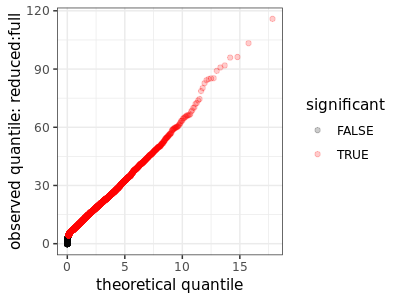

In [91]:
options(repr.plot.width = 4, repr.plot.height = 3, repr.plot.res = 100)
plot_qq(so_3, test = 'reduced:full', test_type = 'lrt', sig_level = 0.05)

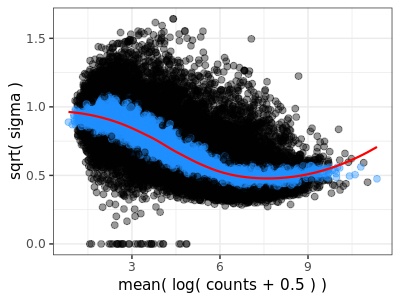

In [92]:
plot_mean_var(so_3, which_model="full")

# 4. Contrast: **non_primordium vs primordium** - reverse of the 3. contrast!
* using only meristem + flower tissues, 
* targeting tissue difference, 
* correcting with time, 
* mutants excluded
     - `null = dataset + is_primordium + intermediate_tissue`
     - `full = dataset + is_primordium`

In [95]:
# create models
so_4 <- sleuth_fit(so_3, ~is_primordium + intermediate_tissue, 'full')
so_4 <- sleuth_fit(so_3, ~is_primordium, 'reduced')

fitting measurement error models
shrinkage estimation
computing variance of betas
fitting measurement error models
shrinkage estimation
3 NA values were found during variance shrinkage estimation due to mean observation values outside of the range used for the LOESS fit.
The LOESS fit will be repeated using exact computation of the fitted surface to extrapolate the missing values.
These are the target ids with NA values: Horvu_MOREX_2H01G715600, Horvu_MOREX_1H01G527500, Horvu_MOREX_5H01G674500
computing variance of betas


In [102]:
# perform DGE tests
so_4 <- sleuth_lrt(so_4, 'reduced', 'full')
so_4 <- sleuth_wt(so_4, 'intermediate_tissueapex', which_model = "full")

In [103]:
models(so_4)

[  full  ]
formula:  ~intermediate_tissue + is_primordium 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)
 	intermediate_tissueapex
 	intermediate_tissueglume
 	intermediate_tissuelemma
 	intermediate_tissuelodicule
 	intermediate_tissuemeiocyte
 	intermediate_tissuepalea
 	intermediate_tissuerachis
 	intermediate_tissuespike
 	intermediate_tissuestamen
 	is_primordiumyes
[  reduced  ]
formula:  ~is_primordium 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)
 	is_primordiumyes


In [105]:
# exctract and inspect results of wald-test
so_wt4 <- sleuth_results(so_4,'intermediate_tissueapex','wt',which_model="full" ,show_all = FALSE,rename_cols=FALSE)
so_wt_sig4 <- filter(so_wt4, qval < 0.05)
nrow(so_wt_sig4)
table(so_wt_sig4$b>0)

[1] 9441


FALSE  TRUE 
 5141  4300 

In [106]:
# extract and inspect results of lrt
so_lrt4 <- sleuth_results(so_4, 'reduced:full', test_type = 'lrt',show_all=TRUE)
# join two tables into one
so_all4 <- na.omit(merge(so_lrt4, so_wt4, by = "target_id", suffixes = c(".lrt", ".wt")))
head(so_all4, 3)

,target_id,pval.lrt,qval.lrt,test_stat,rss,degrees_free,mean_obs.lrt,var_obs.lrt,tech_var,sigma_sq.lrt,⋯,pval.wt,qval.wt,b,se_b,mean_obs.wt,var_obs.wt,sigma_q_sq,sigma_sq.wt,smooth_sigma_sq.wt,smooth_sigma_sq_pmax
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Horvu_MOREX_1H01G000100,4.189006e-36,1.086168e-34,189.9638,29.27012,9,7.057235,0.2964395,0.0008531772,0.2918480,⋯,0.0003468077,0.001368628,0.4456702,0.1245736,7.057235,0.2964395,0.0008531772,0.04774381,0.05453988,0.05453988
2,Horvu_MOREX_1H01G000300,2.706076e-20,8.338495e-20,113.6069,13.06580,9,5.629061,0.1294272,0.0044887557,0.1261692,⋯,0.0011236536,0.003834086,0.5446435,0.1671925,5.629061,0.1294272,0.0044887557,0.03661650,0.09528981,0.09528981
3,Horvu_MOREX_1H01G000400,3.059737e-19,8.263451e-19,108.4360,21.71830,9,6.719473,0.2240490,0.0014985755,0.2156844,⋯,0.0010790452,0.003698239,0.4952740,0.1515034,6.719473,0.2240490,0.0014985755,0.08043240,0.05852039,0.08043240


In [107]:
# inspect sig genes
table(so_all4$qval.lrt<0.05)
table(so_all4$qval.wt<0.05)
table(so_all4$qval.lrt<0.05,so_all4$qval.wt<0.05)


FALSE  TRUE 
   73 20748 


FALSE  TRUE 
11380  9441 

       
        FALSE  TRUE
  FALSE    68     5
  TRUE  11312  9436

In [108]:
table4 <- select(so_all4, "target_id","test_stat","b","qval.lrt","qval.wt",)
sig4_1 <- filter(table4, qval.lrt <= 0.1)
glimpse(sig4_1)
sig4_05 <- filter(table4, qval.lrt <= 0.05)
glimpse(sig4_05)
sig4_01 <- filter(table4, qval.lrt <= 0.01)
glimpse(sig4_01)
# look at table and few of 0.05
head(sig4_05, 5)

Rows: 20,780
Columns: 5
$ target_id <chr> "Horvu_MOREX_1H01G000100", "Horvu_MOREX_1H01G000300", "Horv…
$ test_stat <dbl> 189.96380, 113.60694, 108.43605, 70.08665, 97.13484, 108.19…
$ b         <dbl> 0.44567023, 0.54464353, 0.49527396, -0.82289174, 0.67748280…
$ qval.lrt  <dbl> 1.086168e-34, 8.338495e-20, 8.263451e-19, 1.859113e-11, 1.2…
$ qval.wt   <dbl> 1.368628e-03, 3.834086e-03, 3.698239e-03, 4.170744e-09, 4.7…
Rows: 20,748
Columns: 5
$ target_id <chr> "Horvu_MOREX_1H01G000100", "Horvu_MOREX_1H01G000300", "Horv…
$ test_stat <dbl> 189.96380, 113.60694, 108.43605, 70.08665, 97.13484, 108.19…
$ b         <dbl> 0.44567023, 0.54464353, 0.49527396, -0.82289174, 0.67748280…
$ qval.lrt  <dbl> 1.086168e-34, 8.338495e-20, 8.263451e-19, 1.859113e-11, 1.2…
$ qval.wt   <dbl> 1.368628e-03, 3.834086e-03, 3.698239e-03, 4.170744e-09, 4.7…
Rows: 20,666
Columns: 5
$ target_id <chr> "Horvu_MOREX_1H01G000100", "Horvu_MOREX_1H01G000300", "Horv…
$ test_stat <dbl> 189.96380, 113.60694, 108.43605, 70.08665

,target_id,test_stat,b,qval.lrt,qval.wt
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,Horvu_MOREX_1H01G000100,189.96380,0.4456702,1.086168e-34,1.368628e-03
2,Horvu_MOREX_1H01G000300,113.60694,0.5446435,8.338495e-20,3.834086e-03
3,Horvu_MOREX_1H01G000400,108.43605,0.4952740,8.263451e-19,3.698239e-03
4,Horvu_MOREX_1H01G000500,70.08665,-0.8228917,1.859113e-11,4.170744e-09
5,Horvu_MOREX_1H01G000600,97.13484,0.6774828,1.204249e-16,4.750322e-07


In [109]:
# save 3 sets of DEGs in .csv
setwd("/nfs/pgsb/projects/comparative_triticeae/phenotype/flower_development/refsets/hordeum/")
write.table(sig4_1, file = "deg4_signif0_1.csv", sep = ",", col.names = TRUE)
write.table(sig4_05, file = "deg4_signif0_05.csv", sep = ",", col.names = TRUE)
write.table(sig4_01, file = "deg4_signif0_01.csv", sep = ",", col.names = TRUE)

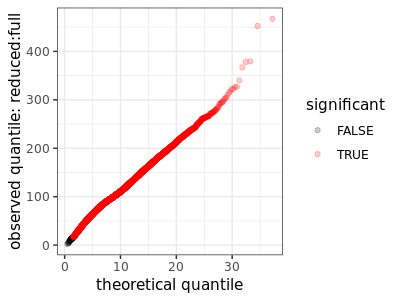

In [110]:
options(repr.plot.width = 4, repr.plot.height = 3, repr.plot.res = 100)
plot_qq(so_4, test = 'reduced:full', test_type = 'lrt', sig_level = 0.05)

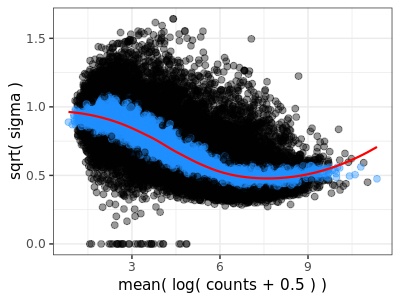

In [111]:
plot_mean_var(so_4, which_model="full")

# 5. **floret_dev vs heading/anthesis stage** 
* targeting time difference (is_heading), 
* correcting with tissues using intermediate_tissue, 
* only reproductive, mutants excluded:
     **barley**: using only flower tissues
     - `null = instrument + intermediate_tissue`
     - `full = instrument + intermediate_tissue + is_anthesis`
     **wheat**: using only anther+flower
     - `null = dataset`
     - `full = dataset + is_heading`
## Create contrast variables
* **is_anthesis**: yes = Anthesis high_level_age, no = Floret_development, high_level_age
* **is_heading**: yes = Heading high_level_age, no = Floret_development high_level_age

In [211]:
# here filter to flower tissues only
# dont use library in barley as only paired reads are selected!
# also, intermed_tissue singular with is_anthesis...
is_flower <- b_meta %>% filter(gm == "wt") %>%
                        filter(high_level_age == "Reproductive") %>%
                        filter(high_level_tissue == "inflorescence") %>% 
                        select(ID, instrument, dataset, intermediate_tissue, intermediate_age) 
# here we select samples that are anther/stamen tissue
is_anthesis_yes <- is_flower %>% filter(intermediate_age == "Anthesis") %>% 
                                add_column(is_anthesis = "yes") %>% 
                                select(ID, instrument, dataset, intermediate_tissue, is_anthesis)
# here we select samples that are not anther/stamen, but are flower
is_anthesis_no <- is_flower %>% filter(intermediate_age == "Floret_development") %>% 
                                add_column(is_anthesis = "no") %>% 
                                select(ID, instrument, dataset, intermediate_tissue, is_anthesis)
# here we join tables of anther or not into one table
b_5 <- bind_rows(is_anthesis_yes, is_anthesis_no)
#glimpse(b_5)
# create variable is_anther
#is_anther_yes <- b_5 %>% filter(intermediate_tissue == "anther" | intermediate_tissue == "meiocyte") %>%
#                        add_column(is_anther = "yes") %>% 
#                        select(ID, instrument, dataset, is_anthesis, is_anther)
#is_anther_no <- b_5 %>% filter(intermediate_tissue != "anther" | intermediate_tissue != "meiocyte") %>%
#                        add_column(is_anther = "no") %>% 
#                        select(ID, instrument, dataset,is_anthesis, is_anther)
# here we join tables of anther or not into one table
#b_5 <- bind_rows(is_anther_yes, is_anther_no)
b_5$ID <- as.factor(b_5$ID)
b_5$instrument <- as.factor(b_5$instrument)
b_5$is_anthesis <- as.factor(b_5$is_anthesis)
#b_5$is_anther <- as.factor(b_5$is_anther)
b_5$intermediate_tissue <- as.factor(b_5$intermediate_tissue)
b_5$dataset <- as.factor(b_5$dataset)
# inspect ratios
glimpse(is_flower)
glimpse(is_anthesis_yes)
glimpse(is_anthesis_no)
#glimpse(is_anther_yes)
#glimpse(is_anther_no)
# inspect full dataset
glimpse(b_5)
tail(b_5, 3)

Rows: 71
Columns: 5
$ ID                  <chr> "ERR1248084", "ERR1248085", "ERR1248086", "ERR124…
$ instrument          <chr> "Illumina HiSeq 2000", "Illumina HiSeq 2000", "Il…
$ dataset             <chr> "drought", "drought", "drought", "drought", "drou…
$ intermediate_tissue <chr> "spike", "spike", "spike", "spike", "spike", "spi…
$ intermediate_age    <chr> "Floret_development", "Floret_development", "Flor…
Rows: 24
Columns: 5
$ ID                  <chr> "ERR1457215", "ERR1457216", "ERR1457217", "ERR145…
$ instrument          <chr> "Illumina HiSeq 2000", "Illumina HiSeq 2000", "Il…
$ dataset             <chr> "developmental_stages", "developmental_stages", "…
$ intermediate_tissue <chr> "lemma", "lemma", "lemma", "lodicule", "lodicule"…
$ is_anthesis         <chr> "yes", "yes", "yes", "yes", "yes", "yes", "yes", …
Rows: 38
Columns: 5
$ ID                  <chr> "ERR1248084", "ERR1248085", "ERR1248086", "ERR124…
$ instrument          <chr> "Illumina HiSeq 2000", "Illumina HiSeq 2000

,ID,instrument,dataset,intermediate_tissue,is_anthesis
,<fct>,<fct>,<fct>,<fct>,<fct>
60,SRR9890004,Illumina NextSeq 550,meiosis,anther,no
61,SRR9890005,Illumina NextSeq 550,meiosis,meiocyte,no
62,SRR9890006,Illumina NextSeq 550,meiosis,meiocyte,no


In [212]:
setwd("/nfs/pgsb/projects/comparative_triticeae/phenotype/flower_development/refsets/hordeum/04_Kallisto_allreads_symlinked/")
files <- file.path("..", "04_Kallisto_allreads_symlinked", b_5$ID, "abundance.h5")
names(files) <- paste0(b_5$ID)
head(files)
all(file.exists(files))

ERR1457215 
"../04_Kallisto_allreads_symlinked/ERR1457215/abundance.h5" 
                                                 ERR1457216 
"../04_Kallisto_allreads_symlinked/ERR1457216/abundance.h5" 
                                                 ERR1457217 
"../04_Kallisto_allreads_symlinked/ERR1457217/abundance.h5" 
                                                 ERR1457218 
"../04_Kallisto_allreads_symlinked/ERR1457218/abundance.h5" 
                                                 ERR1457219 
"../04_Kallisto_allreads_symlinked/ERR1457219/abundance.h5" 
                                                 ERR1457220 
"../04_Kallisto_allreads_symlinked/ERR1457220/abundance.h5"

[1] TRUE

In [213]:
s2c_5 <- mutate(b_5, path = files, sample = ID)
head(s2c_5, 3)

,ID,instrument,dataset,intermediate_tissue,is_anthesis,path,sample
,<fct>,<fct>,<fct>,<fct>,<fct>,<chr>,<fct>
1,ERR1457215,Illumina HiSeq 2000,developmental_stages,lemma,yes,../04_Kallisto_allreads_symlinked/ERR1457215/abundance.h5,ERR1457215
2,ERR1457216,Illumina HiSeq 2000,developmental_stages,lemma,yes,../04_Kallisto_allreads_symlinked/ERR1457216/abundance.h5,ERR1457216
3,ERR1457217,Illumina HiSeq 2000,developmental_stages,lemma,yes,../04_Kallisto_allreads_symlinked/ERR1457217/abundance.h5,ERR1457217


In [214]:
# construct the sleuth-object
so_5 <- sleuth_prep(sample_to_covariates = s2c_5, 
                  target_mapping = m,
                  extra_bootstrap_summary = TRUE,
                  aggregation_column="gene",
                  gene_mode = TRUE,
                  num_cores=1)

'gene_mode' is TRUE. Sleuth will do counts aggregation at the gene level for downstream normalization, transformation, and modeling steps, as well as for plotting and results.
reading in kallisto results
dropping unused factor levels
..............................................................
normalizing est_counts
21802 targets passed the filter
normalizing tpm
merging in metadata
aggregating by column: gene
21802 genes passed the filter
summarizing bootstraps
.................................................
.............


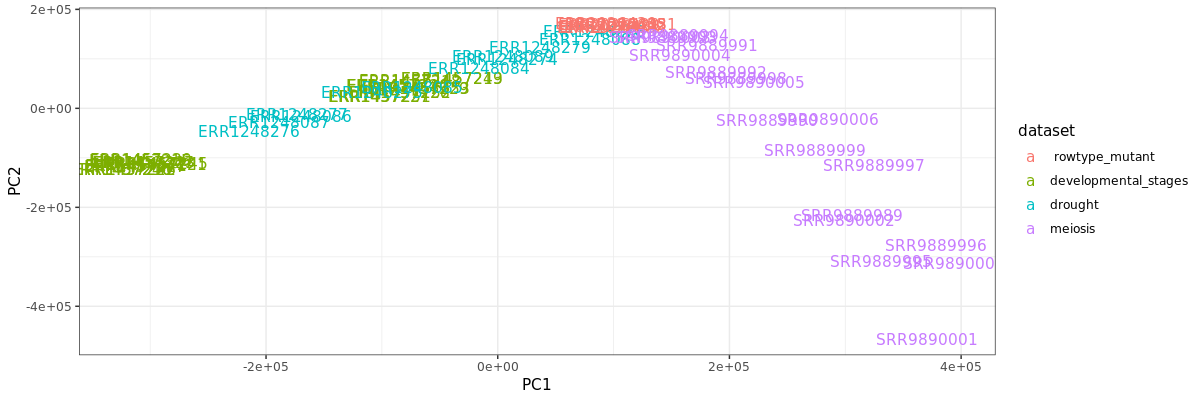

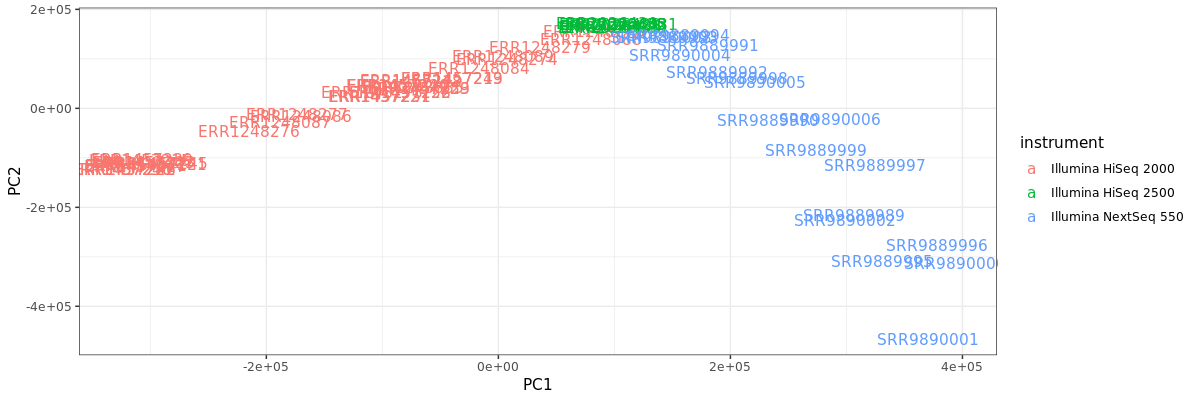

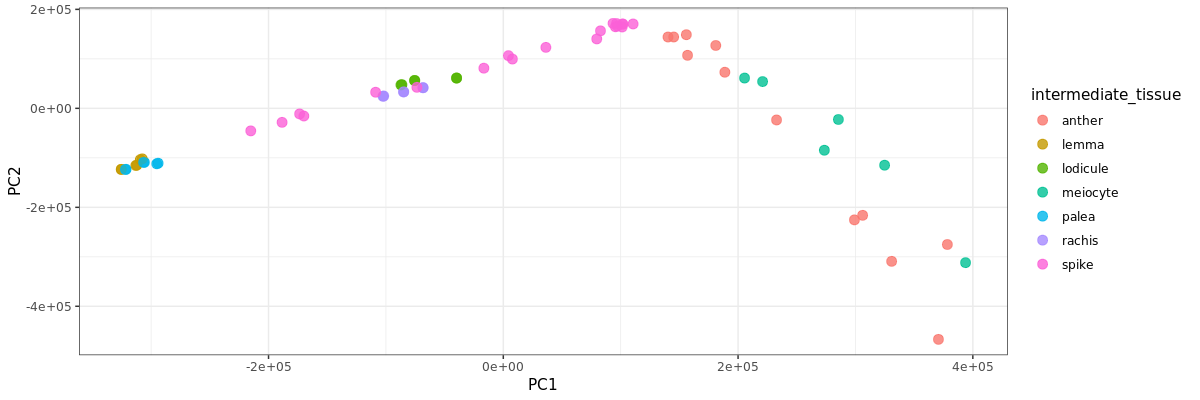

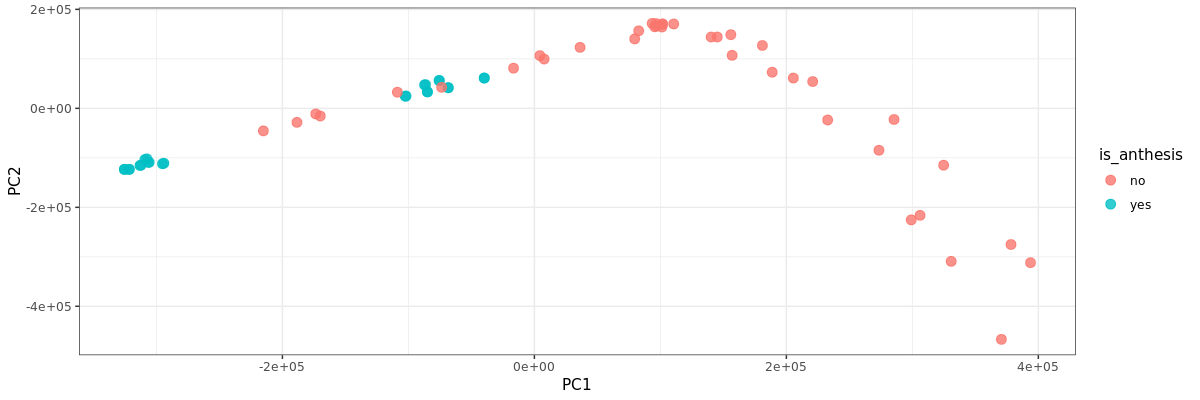

In [216]:
# check for pca
options(repr.plot.width = 12, repr.plot.height = 4, repr.plot.res = 100)
plot_pca(so_5, color_by = 'dataset',text_labels = TRUE,units='scaled_reads_per_base')
plot_pca(so_5, color_by = 'instrument',text_labels = TRUE,units='scaled_reads_per_base')
plot_pca(so_5, color_by = 'intermediate_tissue',text_labels = FALSE,units='scaled_reads_per_base')
plot_pca(so_5, color_by = 'is_anthesis',text_labels = FALSE,units='scaled_reads_per_base')
# two main outliers from developmental stages dataset are rachis samples
# ERR1457171
# ERR1457170
# after excluding them the next new outlier ERR1457196 is a rachis sample from dataset as well

In [217]:
# create models
so_5 <- sleuth_fit(so_5, ~instrument + is_anthesis, 'full')
so_5 <- sleuth_fit(so_5, ~instrument, 'reduced')

fitting measurement error models
shrinkage estimation
computing variance of betas
fitting measurement error models
shrinkage estimation
computing variance of betas


In [218]:
# perform DGE tests
so_5 <- sleuth_lrt(so_5, 'reduced', 'full')
so_5 <- sleuth_wt(so_5, 'is_anthesisyes', which_model = "full")

In [219]:
models(so_5)

[  full  ]
formula:  ~instrument + is_anthesis 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)
 	instrumentIllumina HiSeq 2500
 	instrumentIllumina NextSeq 550
 	is_anthesisyes
[  reduced  ]
formula:  ~instrument 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)
 	instrumentIllumina HiSeq 2500
 	instrumentIllumina NextSeq 550


In [220]:
# exctract and inspect results of wald-test
so_wt5 <- sleuth_results(so_5,'is_anthesisyes','wt',which_model="full" ,show_all = FALSE,rename_cols=FALSE)
so_wt_sig5 <- filter(so_wt5, qval < 0.05)
nrow(so_wt_sig5)
table(so_wt_sig5$b>0)

[1] 11754


FALSE  TRUE 
 6055  5699 

In [221]:
# extract and inspect results of lrt
so_lrt5 <- sleuth_results(so_5, 'reduced:full', test_type = 'lrt',show_all=TRUE)
# join two tables into one
so_all5 <- na.omit(merge(so_lrt5, so_wt5, by = "target_id", suffixes = c(".lrt", ".wt")))
head(so_all5, 3)

,target_id,pval.lrt,qval.lrt,test_stat,rss,degrees_free,mean_obs.lrt,var_obs.lrt,tech_var,sigma_sq.lrt,⋯,pval.wt,qval.wt,b,se_b,mean_obs.wt,var_obs.wt,sigma_q_sq,sigma_sq.wt,smooth_sigma_sq.wt,smooth_sigma_sq_pmax
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Horvu_MOREX_1H01G000100,6.955119e-08,4.515649e-07,29.077187,5.315505,1,7.275519,0.4021400,0.000579754,0.08951355,⋯,2.134893e-08,1.428197e-07,0.5080741,0.09071619,7.275519,0.4021400,0.000579754,0.05546146,0.06525566,0.06525566
2,Horvu_MOREX_1H01G000300,1.724142e-01,1.975704e-01,1.861826,9.826185,1,5.794566,0.1907003,0.003567044,0.16297847,⋯,1.766183e-01,2.496844e-01,-0.1936136,0.14328576,5.794566,0.1907003,0.003567044,0.16067943,0.12566692,0.16067943
3,Horvu_MOREX_1H01G000400,1.636100e-01,1.881541e-01,1.940539,10.545379,1,6.761301,0.2948646,0.001415921,0.17731932,⋯,1.678711e-01,2.394926e-01,-0.2045759,0.14834263,6.761301,0.2948646,0.001415921,0.17462837,0.07532595,0.17462837


In [222]:
# inspect sig genes
table(so_all5$qval.lrt<0.05)
table(so_all5$qval.wt<0.05)
table(so_all5$qval.lrt<0.05,so_all5$qval.wt<0.05)


FALSE  TRUE 
 4381 17421 


FALSE  TRUE 
10048 11754 

       
        FALSE  TRUE
  FALSE  4381     0
  TRUE   5667 11754

In [223]:
table5 <- select(so_all5, "target_id","test_stat","b","qval.lrt","qval.wt",)
sig5_1 <- filter(table5, qval.lrt <= 0.1)
glimpse(sig5_1)
sig5_05 <- filter(table5, qval.lrt <= 0.05)
glimpse(sig5_05)
sig5_01 <- filter(table5, qval.lrt <= 0.01)
glimpse(sig5_01)
# look at table and few of 0.05
head(sig5_05, 5)

Rows: 18,202
Columns: 5
$ target_id <chr> "Horvu_MOREX_1H01G000100", "Horvu_MOREX_1H01G000500", "Horv…
$ test_stat <dbl> 29.077187, 4.530803, 34.578820, 11.760715, 17.295507, 16.22…
$ b         <dbl> 0.50807406, 0.05269786, -0.55039928, 0.13345692, 0.30298158…
$ qval.lrt  <dbl> 4.515649e-07, 4.208688e-02, 3.558351e-08, 1.111126e-03, 9.4…
$ qval.wt   <dbl> 1.428197e-07, 6.348629e-01, 1.631126e-08, 2.189114e-01, 3.7…
Rows: 17,421
Columns: 5
$ target_id <chr> "Horvu_MOREX_1H01G000100", "Horvu_MOREX_1H01G000500", "Horv…
$ test_stat <dbl> 29.077187, 4.530803, 34.578820, 11.760715, 17.295507, 16.22…
$ b         <dbl> 0.50807406, 0.05269786, -0.55039928, 0.13345692, 0.30298158…
$ qval.lrt  <dbl> 4.515649e-07, 4.208688e-02, 3.558351e-08, 1.111126e-03, 9.4…
$ qval.wt   <dbl> 1.428197e-07, 6.348629e-01, 1.631126e-08, 2.189114e-01, 3.7…
Rows: 15,478
Columns: 5
$ target_id <chr> "Horvu_MOREX_1H01G000100", "Horvu_MOREX_1H01G000600", "Horv…
$ test_stat <dbl> 29.077187, 34.578820, 11.760715, 17.29550

,target_id,test_stat,b,qval.lrt,qval.wt
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,Horvu_MOREX_1H01G000100,29.077187,0.50807406,4.515649e-07,1.428197e-07
2,Horvu_MOREX_1H01G000500,4.530803,0.05269786,4.208688e-02,6.348629e-01
3,Horvu_MOREX_1H01G000600,34.578820,-0.55039928,3.558351e-08,1.631126e-08
4,Horvu_MOREX_1H01G000700,11.760715,0.13345692,1.111126e-03,2.189114e-01
5,Horvu_MOREX_1H01G000800,17.295507,0.30298158,9.430018e-05,3.719069e-03


In [224]:
# save 3 sets of DEGsin .csv
setwd("/nfs/pgsb/projects/comparative_triticeae/phenotype/flower_development/refsets/hordeum/")
write.table(sig5_1, file = "deg5_signif0_1.csv", sep = ",", col.names = TRUE)
write.table(sig5_05, file = "deg5_signif0_05.csv", sep = ",", col.names = TRUE)
write.table(sig5_01, file = "deg5_signif0_01.csv", sep = ",", col.names = TRUE)

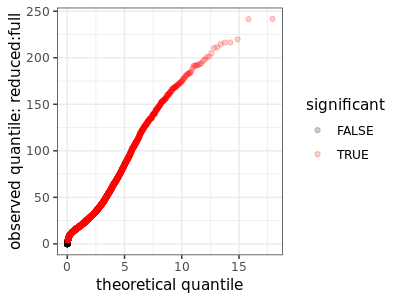

In [225]:
options(repr.plot.width = 4, repr.plot.height = 3, repr.plot.res = 100)
plot_qq(so_5, test = 'reduced:full', test_type = 'lrt', sig_level = 0.05)

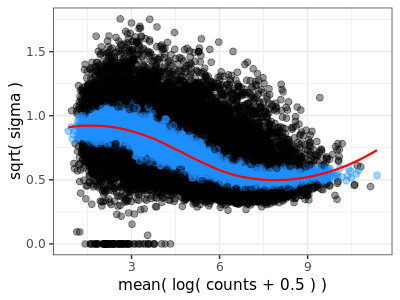

In [226]:
plot_mean_var(so_5, which_model="full")

# 6. **floret_dev vs heading stage** 
* targeting time difference (is_heading), 
* correcting with tissues using intermediate_tissue, 
* only reproductive, mutants excluded:
     **barley**: using only flower tissues
     - `null = instrument + is_booting`
     - `full = instrument + is_booting`
     **wheat**: using only anther
     - `null = dataset`
     - `full = dataset + is_heading`
## Create contrast variables
* **is_anthesis**: yes = Anthesis high_level_age, no = Floret_development, high_level_age
* **is_heading**: yes = Heading high_level_age, no = Floret_development high_level_age

In [234]:
# here filter to flower tissues only
# dont use library in barley as only paired reads are selected!
# also, intermed_tissue singular with is_anthesis...
is_flower <- b_meta %>% filter(gm == "wt") %>%
                        filter(high_level_age == "Reproductive") %>%
                        filter(high_level_tissue == "inflorescence") %>% 
                        select(ID, instrument, dataset, intermediate_tissue, intermediate_age) 
# here we select samples that are anther/stamen tissue
is_anthesis_yes <- is_flower %>% filter(intermediate_age == "Stem_elongation") %>% 
                                add_column(is_anthesis = "yes") %>% 
                                select(ID, instrument, dataset, intermediate_tissue, is_anthesis)
# here we select samples that are not anther/stamen, but are flower
is_anthesis_no <- is_flower %>% filter(intermediate_age == "Floret_development") %>% 
                                add_column(is_anthesis = "no") %>% 
                                select(ID, instrument, dataset, intermediate_tissue, is_anthesis)
# here we join tables of anther or not into one table
b_6 <- bind_rows(is_anthesis_yes, is_anthesis_no)
#glimpse(b_5)
# create variable is_anther
#is_anther_yes <- b_5 %>% filter(intermediate_tissue == "anther" | intermediate_tissue == "meiocyte") %>%
#                        add_column(is_anther = "yes") %>% 
#                        select(ID, instrument, dataset, is_anthesis, is_anther)
#is_anther_no <- b_5 %>% filter(intermediate_tissue != "anther" | intermediate_tissue != "meiocyte") %>%
#                        add_column(is_anther = "no") %>% 
#                        select(ID, instrument, dataset,is_anthesis, is_anther)
# here we join tables of anther or not into one table
#b_5 <- bind_rows(is_anther_yes, is_anther_no)
b_6$ID <- as.factor(b_6$ID)
b_6$instrument <- as.factor(b_6$instrument)
b_6$is_anthesis <- as.factor(b_6$is_anthesis)
#b_5$is_anther <- as.factor(b_5$is_anther)
b_6$intermediate_tissue <- as.factor(b_6$intermediate_tissue)
b_6$dataset <- as.factor(b_6$dataset)
# inspect ratios
glimpse(is_flower)
glimpse(is_anthesis_yes)
glimpse(is_anthesis_no)
#glimpse(is_anther_yes)
#glimpse(is_anther_no)
# inspect full dataset
glimpse(b_6)
tail(b_6, 3)

Rows: 71
Columns: 5
$ ID                  <chr> "ERR1248084", "ERR1248085", "ERR1248086", "ERR124…
$ instrument          <chr> "Illumina HiSeq 2000", "Illumina HiSeq 2000", "Il…
$ dataset             <chr> "drought", "drought", "drought", "drought", "drou…
$ intermediate_tissue <chr> "spike", "spike", "spike", "spike", "spike", "spi…
$ intermediate_age    <chr> "Floret_development", "Floret_development", "Flor…
Rows: 9
Columns: 5
$ ID                  <chr> "ERR1457178", "ERR1457179", "ERR1457180", "ERR145…
$ instrument          <chr> "Illumina HiSeq 2000", "Illumina HiSeq 2000", "Il…
$ dataset             <chr> "developmental_stages", "developmental_stages", "…
$ intermediate_tissue <chr> "spike", "spike", "spike", "spike", "spike", "spi…
$ is_anthesis         <chr> "yes", "yes", "yes", "yes", "yes", "yes", "yes", …
Rows: 38
Columns: 5
$ ID                  <chr> "ERR1248084", "ERR1248085", "ERR1248086", "ERR124…
$ instrument          <chr> "Illumina HiSeq 2000", "Illumina HiSeq 2000"

,ID,instrument,dataset,intermediate_tissue,is_anthesis
,<fct>,<fct>,<fct>,<fct>,<fct>
45,SRR9890004,Illumina NextSeq 550,meiosis,anther,no
46,SRR9890005,Illumina NextSeq 550,meiosis,meiocyte,no
47,SRR9890006,Illumina NextSeq 550,meiosis,meiocyte,no


In [235]:
setwd("/nfs/pgsb/projects/comparative_triticeae/phenotype/flower_development/refsets/hordeum/04_Kallisto_allreads_symlinked/")
files <- file.path("..", "04_Kallisto_allreads_symlinked", b_6$ID, "abundance.h5")
names(files) <- paste0(b_6$ID)
head(files)
all(file.exists(files))

ERR1457178 
"../04_Kallisto_allreads_symlinked/ERR1457178/abundance.h5" 
                                                 ERR1457179 
"../04_Kallisto_allreads_symlinked/ERR1457179/abundance.h5" 
                                                 ERR1457180 
"../04_Kallisto_allreads_symlinked/ERR1457180/abundance.h5" 
                                                 ERR1457203 
"../04_Kallisto_allreads_symlinked/ERR1457203/abundance.h5" 
                                                 ERR1457204 
"../04_Kallisto_allreads_symlinked/ERR1457204/abundance.h5" 
                                                 ERR1457205 
"../04_Kallisto_allreads_symlinked/ERR1457205/abundance.h5"

[1] TRUE

In [236]:
s2c_6 <- mutate(b_6, path = files, sample = ID)
head(s2c_6, 3)

,ID,instrument,dataset,intermediate_tissue,is_anthesis,path,sample
,<fct>,<fct>,<fct>,<fct>,<fct>,<chr>,<fct>
1,ERR1457178,Illumina HiSeq 2000,developmental_stages,spike,yes,../04_Kallisto_allreads_symlinked/ERR1457178/abundance.h5,ERR1457178
2,ERR1457179,Illumina HiSeq 2000,developmental_stages,spike,yes,../04_Kallisto_allreads_symlinked/ERR1457179/abundance.h5,ERR1457179
3,ERR1457180,Illumina HiSeq 2000,developmental_stages,spike,yes,../04_Kallisto_allreads_symlinked/ERR1457180/abundance.h5,ERR1457180


In [237]:
# construct the sleuth-object
so_6 <- sleuth_prep(sample_to_covariates = s2c_6, 
                  target_mapping = m,
                  extra_bootstrap_summary = TRUE,
                  aggregation_column="gene",
                  gene_mode = TRUE,
                  num_cores=1)

'gene_mode' is TRUE. Sleuth will do counts aggregation at the gene level for downstream normalization, transformation, and modeling steps, as well as for plotting and results.
reading in kallisto results
dropping unused factor levels
...............................................
normalizing est_counts
21601 targets passed the filter
normalizing tpm
merging in metadata
aggregating by column: gene
21601 genes passed the filter
summarizing bootstraps
...............................................


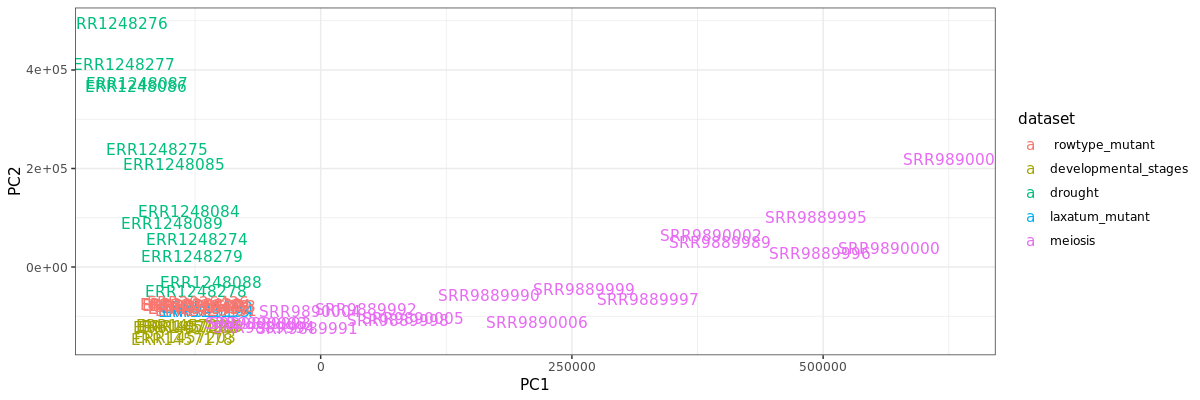

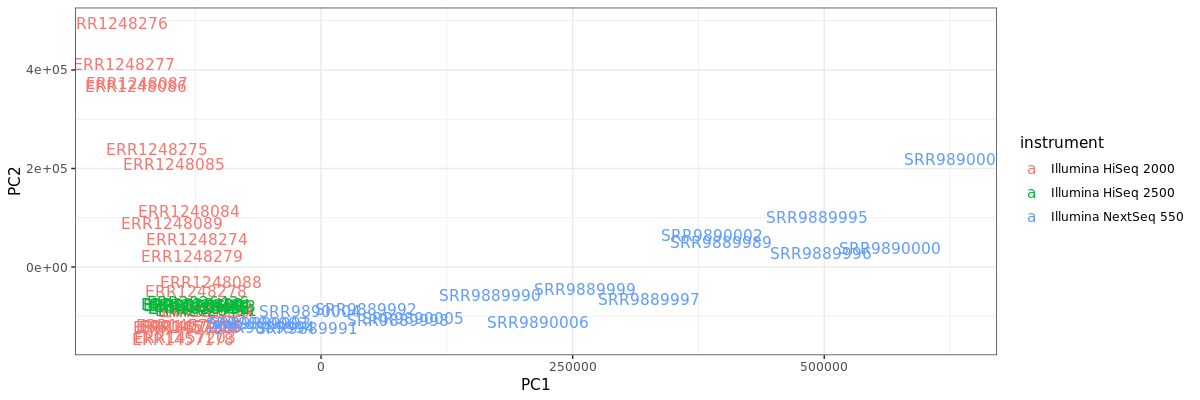

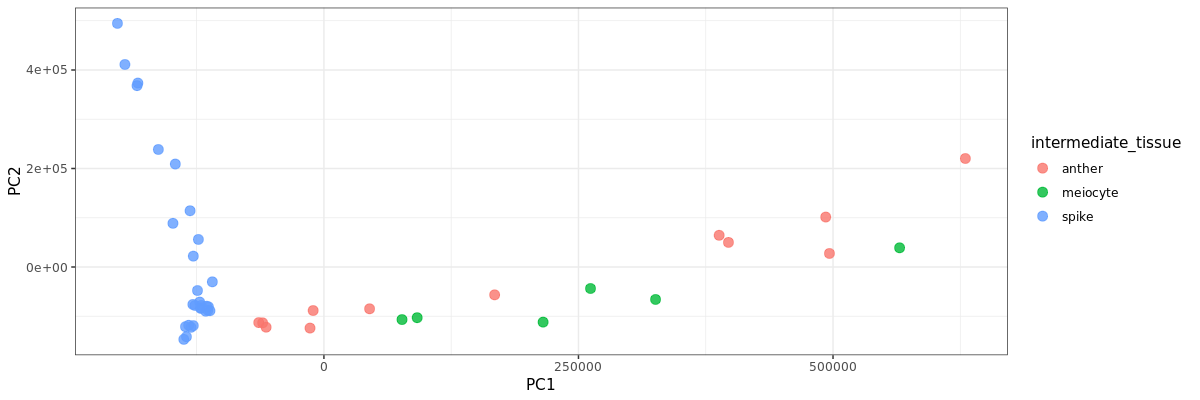

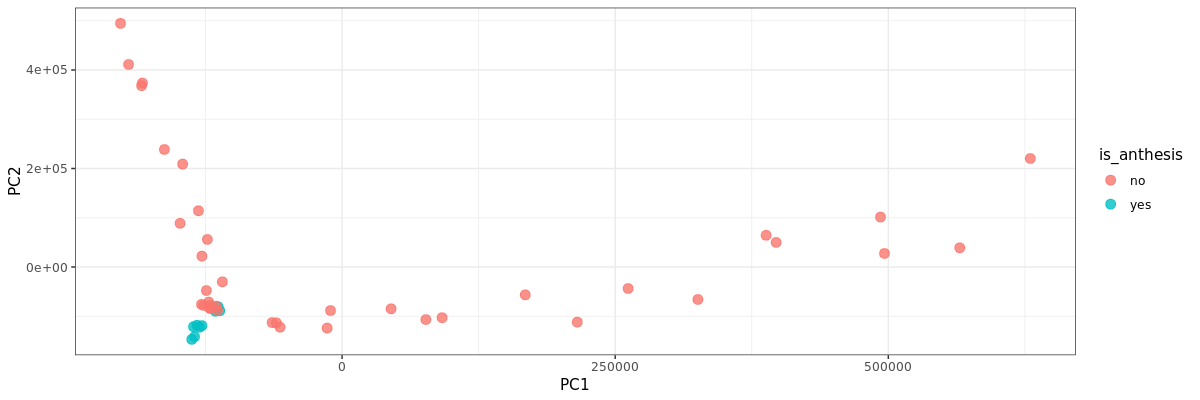

In [240]:
# check for pca
options(repr.plot.width = 12, repr.plot.height = 4, repr.plot.res = 100)
plot_pca(so_6, color_by = 'dataset',text_labels = TRUE,units='scaled_reads_per_base')
plot_pca(so_6, color_by = 'instrument',text_labels = TRUE,units='scaled_reads_per_base')
plot_pca(so_6, color_by = 'intermediate_tissue',text_labels = FALSE,units='scaled_reads_per_base')
plot_pca(so_6, color_by = 'is_anthesis',text_labels = FALSE,units='scaled_reads_per_base')
# two main outliers from developmental stages dataset are rachis samples
# ERR1457171
# ERR1457170
# after excluding them the next new outlier ERR1457196 is a rachis sample from dataset as well

In [258]:
# create models
so_6 <- sleuth_fit(so_6, ~intermediate_tissue + is_anthesis, 'full')
so_6 <- sleuth_fit(so_6, ~intermediate_tissue, 'reduced')

fitting measurement error models
shrinkage estimation
computing variance of betas
fitting measurement error models
shrinkage estimation
computing variance of betas


In [259]:
# perform DGE tests
so_6 <- sleuth_lrt(so_6, 'reduced', 'full')
so_6 <- sleuth_wt(so_6, 'is_anthesisyes', which_model = "full")

In [260]:
models(so_6)

[  full  ]
formula:  ~intermediate_tissue + is_anthesis 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)
 	intermediate_tissuemeiocyte
 	intermediate_tissuespike
 	is_anthesisyes
[  reduced  ]
formula:  ~intermediate_tissue 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)
 	intermediate_tissuemeiocyte
 	intermediate_tissuespike


In [261]:
# exctract and inspect results of wald-test
so_wt6 <- sleuth_results(so_6,'is_anthesisyes','wt',which_model="full" ,show_all = FALSE,rename_cols=FALSE)
so_wt_sig6 <- filter(so_wt6, qval < 0.05)
nrow(so_wt_sig6)
table(so_wt_sig6$b>0)

[1] 10475


FALSE  TRUE 
 5632  4843 

In [262]:
# extract and inspect results of lrt
so_lrt6 <- sleuth_results(so_6, 'reduced:full', test_type = 'lrt',show_all=TRUE)
# join two tables into one
so_all6 <- na.omit(merge(so_lrt6, so_wt6, by = "target_id", suffixes = c(".lrt", ".wt")))
head(so_all6, 3)

,target_id,pval.lrt,qval.lrt,test_stat,rss,degrees_free,mean_obs.lrt,var_obs.lrt,tech_var,sigma_sq.lrt,⋯,pval.wt,qval.wt,b,se_b,mean_obs.wt,var_obs.wt,sigma_q_sq,sigma_sq.wt,smooth_sigma_sq.wt,smooth_sigma_sq_pmax
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Horvu_MOREX_1H01G000100,0.009246110,0.015841150,6.7746600,3.098163,1,7.131158,0.25636518,0.0007348755,0.06967791,⋯,0.02088961,0.04416093,-0.24788514,0.1073108,7.131158,0.25636518,0.0007348755,0.06244575,0.07074132,0.07074132
2,Horvu_MOREX_1H01G000300,0.001606357,0.004497175,9.9524471,2.706091,1,5.924394,0.09326786,0.0030779965,0.05842406,⋯,0.02408254,0.04972347,-0.31142668,0.1380554,5.924394,0.09326786,0.0030779965,0.04585468,0.11522102,0.11522102
3,Horvu_MOREX_1H01G000400,0.585530962,0.608006317,0.2973779,5.190885,1,7.002798,0.27724513,0.0010128309,0.11696183,⋯,0.55574892,0.64668085,-0.08183557,0.1389003,7.002798,0.27724513,0.0010128309,0.11873872,0.07283210,0.11873872


In [263]:
# inspect sig genes
table(so_all6$qval.lrt<0.05)
table(so_all6$qval.wt<0.05)
table(so_all6$qval.lrt<0.05,so_all6$qval.wt<0.05)


FALSE  TRUE 
 4712 16889 


FALSE  TRUE 
11126 10475 

       
        FALSE  TRUE
  FALSE  4712     0
  TRUE   6414 10475

In [264]:
table6 <- select(so_all6, "target_id","test_stat","b","qval.lrt","qval.wt",)
sig6_1 <- filter(table6, qval.lrt <= 0.1)
glimpse(sig6_1)
sig6_05 <- filter(table6, qval.lrt <= 0.05)
glimpse(sig6_05)
sig6_01 <- filter(table6, qval.lrt <= 0.01)
glimpse(sig6_01)
# look at table and few of 0.05
head(sig6_05, 5)

Rows: 18,379
Columns: 5
$ target_id <chr> "Horvu_MOREX_1H01G000100", "Horvu_MOREX_1H01G000300", "Horv…
$ test_stat <dbl> 6.774660, 9.952447, 20.468254, 8.126973, 7.993068, 4.442880…
$ b         <dbl> -0.2478851377, -0.3114266799, -0.5238204332, -0.2168758985,…
$ qval.lrt  <dbl> 1.584115e-02, 4.497175e-03, 7.365787e-05, 9.393279e-03, 9.8…
$ qval.wt   <dbl> 4.416093e-02, 4.972347e-02, 1.602509e-05, 7.268809e-02, 2.1…
Rows: 16,889
Columns: 5
$ target_id <chr> "Horvu_MOREX_1H01G000100", "Horvu_MOREX_1H01G000300", "Horv…
$ test_stat <dbl> 6.774660, 9.952447, 20.468254, 8.126973, 7.993068, 4.442880…
$ b         <dbl> -0.2478851377, -0.3114266799, -0.5238204332, -0.2168758985,…
$ qval.lrt  <dbl> 1.584115e-02, 4.497175e-03, 7.365787e-05, 9.393279e-03, 9.8…
$ qval.wt   <dbl> 4.416093e-02, 4.972347e-02, 1.602509e-05, 7.268809e-02, 2.1…
Rows: 10,306
Columns: 5
$ target_id <chr> "Horvu_MOREX_1H01G000300", "Horvu_MOREX_1H01G000500", "Horv…
$ test_stat <dbl> 9.952447, 20.468254, 8.126973, 7.993068, 

,target_id,test_stat,b,qval.lrt,qval.wt
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,Horvu_MOREX_1H01G000100,6.774660,-0.2478851,1.584115e-02,4.416093e-02
2,Horvu_MOREX_1H01G000300,9.952447,-0.3114267,4.497175e-03,4.972347e-02
3,Horvu_MOREX_1H01G000500,20.468254,-0.5238204,7.365787e-05,1.602509e-05
4,Horvu_MOREX_1H01G000600,8.126973,-0.2168759,9.393279e-03,7.268809e-02
5,Horvu_MOREX_1H01G000700,7.993068,0.1560801,9.893808e-03,2.183730e-01


In [90]:
# save 3 sets of DEGsin .csv
setwd("/nfs/pgsb/projects/comparative_triticeae/phenotype/flower_development/refsets/hordeum/")
write.table(sig6_1, file = "deg6_signif0_1.csv", sep = ",", col.names = TRUE)
write.table(sig6_05, file = "deg6_signif0_05.csv", sep = ",", col.names = TRUE)
write.table(sig6_01, file = "deg6_signif0_01.csv", sep = ",", col.names = TRUE)

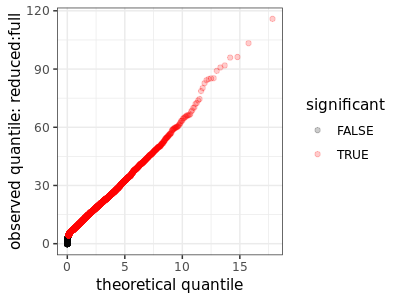

In [91]:
options(repr.plot.width = 4, repr.plot.height = 3, repr.plot.res = 100)
plot_qq(so_6, test = 'reduced:full', test_type = 'lrt', sig_level = 0.05)

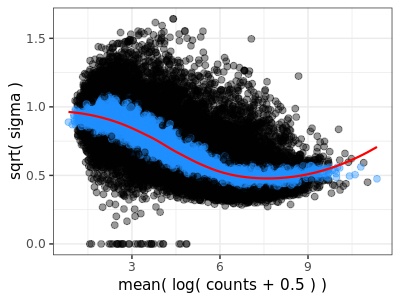

In [92]:
plot_mean_var(so_6, which_model="full")

# 7. Contrast: **flower vs anther**
* using only flower tissues, 
* targeting tissue difference, 
* correcting with time (Zadok_scale),
* mutants excluded
     - `null = instrument + Zadok_scale`
     - `full = instrument + Zadok_scale + is_anther`

## Creating contrast variables
* **is_anther** = yes = only anther wt tissues, no = flower tissues

In [299]:
# here filter to flower tissues only
is_flower <- b_meta %>% filter(gm == "wt") %>%
                        filter(high_level_tissue == "inflorescence") %>% select(ID, dataset, library, instrument, intermediate_age, intermediate_tissue, zadok_scale) 
# here we select samples that are anther/stamen tissue
is_anther_yes <- is_flower %>% filter(intermediate_tissue == "anther" | intermediate_tissue == "stamen" | intermediate_tissue == "meiocyte") %>% 
                                              add_column(is_anther = "yes") %>% 
                                              select(ID, dataset, library, instrument, intermediate_age, zadok_scale, is_anther)
# here we select samples that are not anther/stamen, but are flower
is_anther_no <- is_flower %>% filter(intermediate_tissue != "anther" & intermediate_tissue != "stamen" & intermediate_tissue != "meiocyte") %>% 
                                              add_column(is_anther = "no") %>% 
                                              select(ID, dataset, library, instrument, intermediate_age, zadok_scale, is_anther)
# here we join tables of anther or not into one table
b_7 <- bind_rows(is_anther_yes, is_anther_no)
b_7$ID <- as.factor(b_7$ID)
b_7$instrument <- as.factor(b_7$instrument)
b_7$is_anther <- as.factor(b_7$is_anther)
b_7$zadok_scale <- as.factor(b_7$zadok_scale)
b_7$library <- as.factor(b_7$library)
b_7$dataset <- as.factor(b_7$dataset)
b_7$intermediate_age <- as.factor(b_7$intermediate_age)
# inspect ratios
glimpse(is_flower)
glimpse(is_anther_yes)
glimpse(is_anther_no)
# inspect full dataset
glimpse(b_7)
tail(b_7, 3)

Rows: 91
Columns: 7
$ ID                  <chr> "ERR1248084", "ERR1248085", "ERR1248086", "ERR124…
$ dataset             <chr> "drought", "drought", "drought", "drought", "drou…
$ library             <chr> "paired", "paired", "paired", "paired", "paired",…
$ instrument          <chr> "Illumina HiSeq 2000", "Illumina HiSeq 2000", "Il…
$ intermediate_age    <chr> "Floret_development", "Floret_development", "Flor…
$ intermediate_tissue <chr> "spike", "spike", "spike", "spike", "spike", "spi…
$ zadok_scale         <int> 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 3…
Rows: 21
Columns: 7
$ ID               <chr> "SRR9889989", "SRR9889990", "SRR9889991", "SRR988999…
$ dataset          <chr> "meiosis", "meiosis", "meiosis", "meiosis", "meiosis…
$ library          <chr> "paired", "paired", "paired", "paired", "paired", "p…
$ instrument       <chr> "Illumina NextSeq 550", "Illumina NextSeq 550", "Ill…
$ intermediate_age <chr> "Floret_development", "Floret_development", "Floret_…
$ zadok_scal

,ID,dataset,library,instrument,intermediate_age,zadok_scale,is_anther
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
89,ERR515192,laxatum_mutant,paired,Illumina HiSeq 2000,Stem_elongation,31,no
90,ERR515193,laxatum_mutant,paired,Illumina HiSeq 2000,Stem_elongation,31,no
91,ERR515194,laxatum_mutant,paired,Illumina HiSeq 2000,Stem_elongation,31,no


In [300]:
setwd("/nfs/pgsb/projects/comparative_triticeae/phenotype/flower_development/refsets/hordeum/04_Kallisto_allreads_symlinked/")
files <- file.path("..", "04_Kallisto_allreads_symlinked", b_7$ID, "abundance.h5")
names(files) <- paste0(b_7$ID)
head(files)
all(file.exists(files))

SRR9889989 
"../04_Kallisto_allreads_symlinked/SRR9889989/abundance.h5" 
                                                 SRR9889990 
"../04_Kallisto_allreads_symlinked/SRR9889990/abundance.h5" 
                                                 SRR9889991 
"../04_Kallisto_allreads_symlinked/SRR9889991/abundance.h5" 
                                                 SRR9889992 
"../04_Kallisto_allreads_symlinked/SRR9889992/abundance.h5" 
                                                 SRR9889993 
"../04_Kallisto_allreads_symlinked/SRR9889993/abundance.h5" 
                                                 SRR9889994 
"../04_Kallisto_allreads_symlinked/SRR9889994/abundance.h5"

[1] TRUE

In [301]:
s2c_7 <- mutate(b_7, path = files, sample = ID)
head(s2c_7, 3)

,ID,dataset,library,instrument,intermediate_age,zadok_scale,is_anther,path,sample
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<chr>,<fct>
1,SRR9889989,meiosis,paired,Illumina NextSeq 550,Floret_development,39,yes,../04_Kallisto_allreads_symlinked/SRR9889989/abundance.h5,SRR9889989
2,SRR9889990,meiosis,paired,Illumina NextSeq 550,Floret_development,39,yes,../04_Kallisto_allreads_symlinked/SRR9889990/abundance.h5,SRR9889990
3,SRR9889991,meiosis,paired,Illumina NextSeq 550,Floret_development,38,yes,../04_Kallisto_allreads_symlinked/SRR9889991/abundance.h5,SRR9889991


In [302]:
# construct the sleuth-object
so_7 <- sleuth_prep(sample_to_covariates = s2c_7, 
                  target_mapping = m,
                  extra_bootstrap_summary = TRUE,
                 aggregation_column="gene",
                  gene_mode = TRUE,
                 num_cores=1)

'gene_mode' is TRUE. Sleuth will do counts aggregation at the gene level for downstream normalization, transformation, and modeling steps, as well as for plotting and results.
reading in kallisto results
dropping unused factor levels
...........................................................................................
normalizing est_counts
21153 targets passed the filter
normalizing tpm
merging in metadata
aggregating by column: gene
21153 genes passed the filter
summarizing bootstraps
.................................................
..........................................


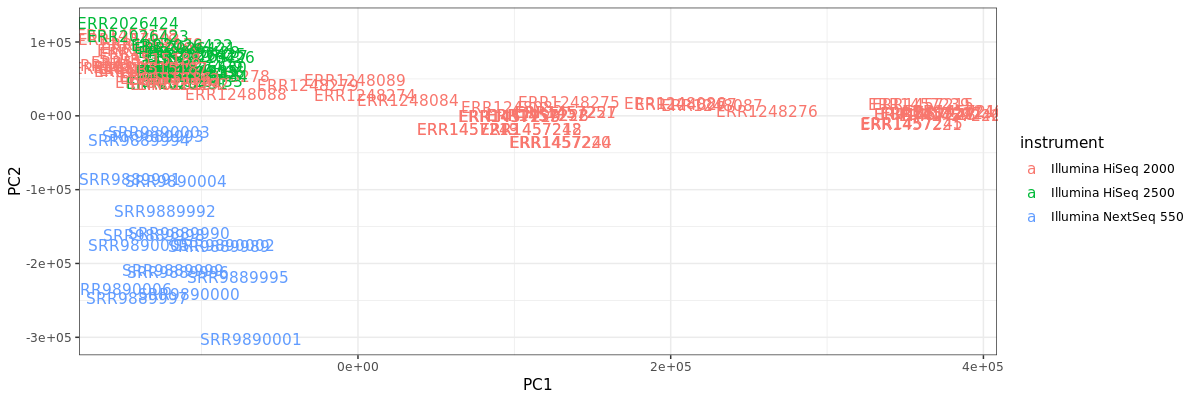

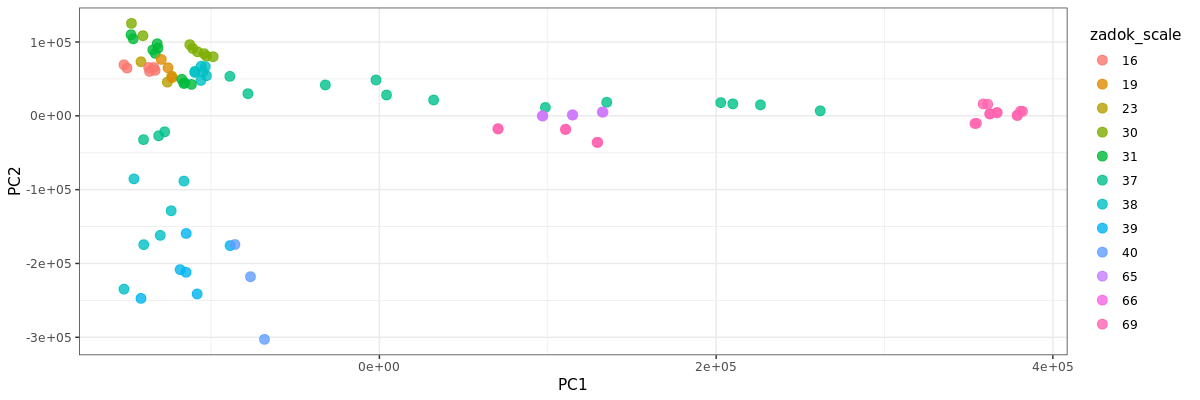

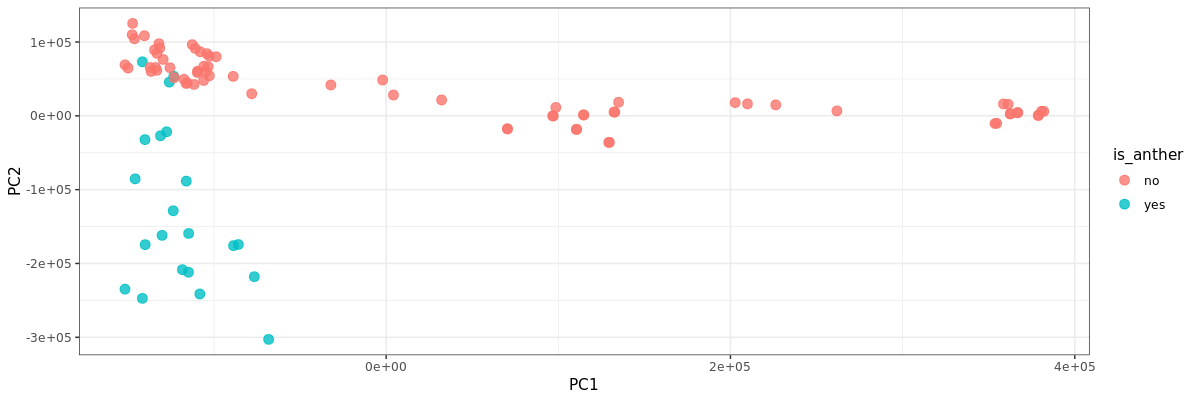

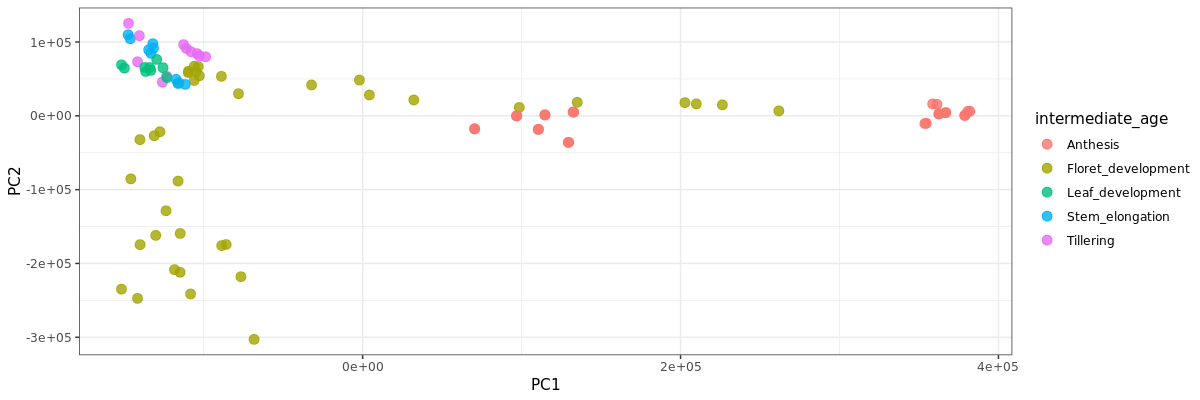

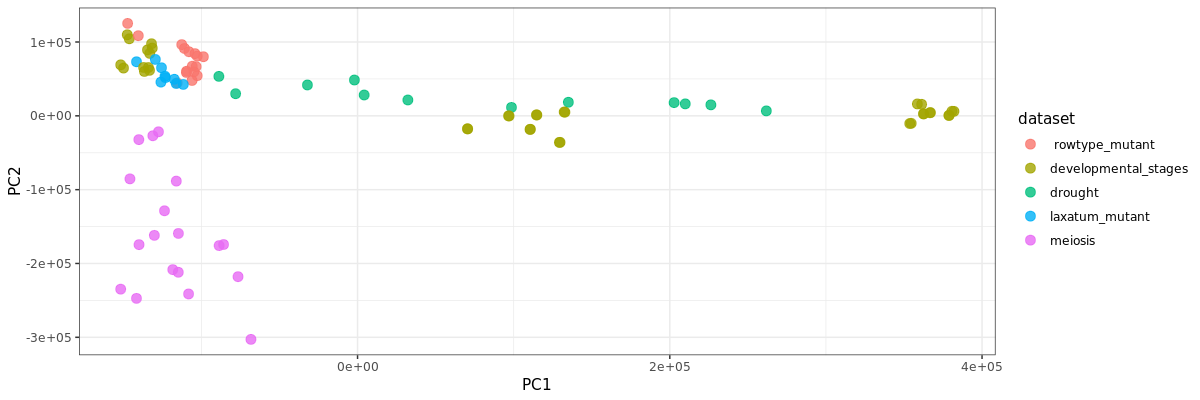

In [304]:
# check for pca
options(repr.plot.width = 12, repr.plot.height = 4, repr.plot.res = 100)
plot_pca(so_7, color_by = 'instrument',text_labels = TRUE,units='scaled_reads_per_base')
plot_pca(so_7, color_by = 'zadok_scale',text_labels = FALSE,units='scaled_reads_per_base')
plot_pca(so_7, color_by = 'is_anther',text_labels = FALSE,units='scaled_reads_per_base')
plot_pca(so_7, color_by = 'intermediate_age',text_labels = FALSE,units='scaled_reads_per_base')
plot_pca(so_7, color_by = 'dataset',text_labels = FALSE,units='scaled_reads_per_base')
# two main outliers from developmental stages dataset are rachis samples
# ERR1457171
# ERR1457170
# after excluding them the next new outlier ERR1457196 is a rachis sample from dataset as well

In [314]:
# create models
so_7 <- sleuth_fit(so_7, ~instrument + intermediate_age + is_anther, 'full')
so_7 <- sleuth_fit(so_7, ~instrument + intermediate_age, 'reduced')

fitting measurement error models
shrinkage estimation
computing variance of betas
fitting measurement error models
shrinkage estimation
computing variance of betas


In [315]:
# perform DGE tests
so_7 <- sleuth_lrt(so_7, 'reduced', 'full')
so_7 <- sleuth_wt(so_7, 'is_antheryes', which_model = "full")

In [316]:
models(so_7)

[  full  ]
formula:  ~instrument + intermediate_age + is_anther 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)
 	instrumentIllumina HiSeq 2500
 	instrumentIllumina NextSeq 550
 	intermediate_ageFloret_development
 	intermediate_ageLeaf_development
 	intermediate_ageStem_elongation
 	intermediate_ageTillering
 	is_antheryes
[  reduced  ]
formula:  ~instrument + intermediate_age 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)
 	instrumentIllumina HiSeq 2500
 	instrumentIllumina NextSeq 550
 	intermediate_ageFloret_development
 	intermediate_ageLeaf_development
 	intermediate_ageStem_elongation
 	intermediate_ageTillering


In [317]:
# exctract and inspect results of wald-test
so_wt7 <- sleuth_results(so_7,'is_antheryes','wt',which_model="full" ,show_all = FALSE,rename_cols=FALSE)
so_wt_sig7 <- filter(so_wt7, qval < 0.05)
nrow(so_wt_sig7)
table(so_wt_sig7$b>0)

[1] 5331


FALSE  TRUE 
 2896  2435 

In [318]:
# extract and inspect results of lrt
so_lrt7 <- sleuth_results(so_7, 'reduced:full', test_type = 'lrt',show_all=TRUE)
# join two tables into one
so_all7 <- na.omit(merge(so_lrt7, so_wt7, by = "target_id", suffixes = c(".lrt", ".wt")))
head(so_all7, 3)

,target_id,pval.lrt,qval.lrt,test_stat,rss,degrees_free,mean_obs.lrt,var_obs.lrt,tech_var,sigma_sq.lrt,⋯,pval.wt,qval.wt,b,se_b,mean_obs.wt,var_obs.wt,sigma_q_sq,sigma_sq.wt,smooth_sigma_sq.wt,smooth_sigma_sq_pmax
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Horvu_MOREX_1H01G000100,2.869356e-05,0.0004999628,17.502463973,4.535592,1,7.187480,0.3116839,0.000696578,0.05329857,⋯,4.279428e-05,0.0007072089,-0.78358948,0.1915000,7.187480,0.3116839,0.000696578,0.0428525,0.05431179,0.05431179
2,Horvu_MOREX_1H01G000300,2.757020e-01,0.3271087485,1.188155242,10.201086,1,5.712407,0.1398521,0.004020681,0.11742081,⋯,2.786092e-01,0.4401986909,-0.30796216,0.2842425,5.712407,0.1398521,0.004020681,0.1171700,0.10269227,0.11716998
3,Horvu_MOREX_1H01G000400,9.301284e-01,0.9676866934,0.007688362,10.762150,1,6.811514,0.2355813,0.001367590,0.12675324,⋯,7.654573e-01,0.8546692883,0.08766325,0.2938544,6.811514,0.2355813,0.001367590,0.1281580,0.06002703,0.12815799


In [319]:
# inspect sig genes
table(so_all7$qval.lrt<0.05)
table(so_all7$qval.wt<0.05)
table(so_all7$qval.lrt<0.05,so_all7$qval.wt<0.05)


FALSE  TRUE 
13104  8049 


FALSE  TRUE 
15822  5331 

       
        FALSE  TRUE
  FALSE 13104     0
  TRUE   2718  5331

In [320]:
table7 <- select(so_all7, "target_id","test_stat","b","qval.lrt","qval.wt",)
sig7_1 <- filter(table7, qval.lrt <= 0.1)
glimpse(sig7_1)
sig7_05 <- filter(table7, qval.lrt <= 0.05)
glimpse(sig7_05)
sig7_01 <- filter(table7, qval.lrt <= 0.01)
glimpse(sig7_01)
# look at table and few of 0.05
head(sig7_05, 5)

Rows: 13,075
Columns: 5
$ target_id <chr> "Horvu_MOREX_1H01G000100", "Horvu_MOREX_1H01G000700", "Horv…
$ test_stat <dbl> 17.502464, 5.738476, 3.833416, 4.186923, 5.444014, 14.86478…
$ b         <dbl> -0.78358948, 0.30251284, -0.09279443, 0.30241007, -2.593350…
$ qval.lrt  <dbl> 4.999628e-04, 4.587485e-02, 8.736803e-02, 7.660489e-02, 5.1…
$ qval.wt   <dbl> 7.072089e-04, 2.478734e-01, 7.681298e-01, 2.289534e-01, 7.5…
Rows: 8,049
Columns: 5
$ target_id <chr> "Horvu_MOREX_1H01G000100", "Horvu_MOREX_1H01G000700", "Horv…
$ test_stat <dbl> 17.502464, 5.738476, 14.864782, 15.682835, 6.398266, 7.7530…
$ b         <dbl> -0.7835895, 0.3025128, 0.7185159, 1.1691865, -0.4701112, -1…
$ qval.lrt  <dbl> 4.999628e-04, 4.587485e-02, 1.407962e-03, 1.017584e-03, 3.6…
$ qval.wt   <dbl> 7.072089e-04, 2.478734e-01, 2.340745e-03, 1.063528e-03, 6.6…
Rows: 3,644
Columns: 5
$ target_id <chr> "Horvu_MOREX_1H01G000100", "Horvu_MOREX_1H01G005100", "Horv…
$ test_stat <dbl> 17.50246, 14.86478, 15.68283, 30.06254, 22.

,target_id,test_stat,b,qval.lrt,qval.wt
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,Horvu_MOREX_1H01G000100,17.502464,-0.7835895,0.0004999628,0.0007072089
2,Horvu_MOREX_1H01G000700,5.738476,0.3025128,0.0458748523,0.2478733908
3,Horvu_MOREX_1H01G005100,14.864782,0.7185159,0.0014079622,0.0023407452
4,Horvu_MOREX_1H01G005200,15.682835,1.1691865,0.0010175836,0.0010635275
5,Horvu_MOREX_1H01G005400,6.398266,-0.4701112,0.0362100563,0.0669676711


In [321]:
# save 3 sets of DEGsin .csv
setwd("/nfs/pgsb/projects/comparative_triticeae/phenotype/flower_development/refsets/hordeum/")
write.table(sig7_1, file = "deg7_signif0_1.csv", sep = ",", col.names = TRUE)
write.table(sig7_05, file = "deg7_signif0_05.csv", sep = ",", col.names = TRUE)
write.table(sig7_01, file = "deg7_signif0_01.csv", sep = ",", col.names = TRUE)

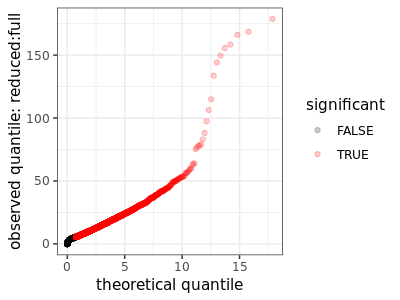

In [322]:
options(repr.plot.width = 4, repr.plot.height = 3, repr.plot.res = 100)
plot_qq(so_7, test = 'reduced:full', test_type = 'lrt', sig_level = 0.05)

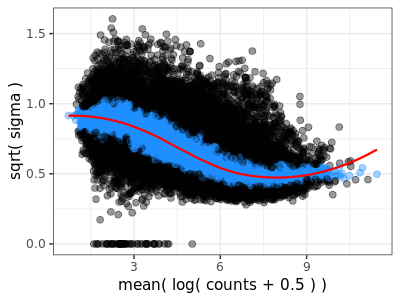

In [323]:
plot_mean_var(so_7, which_model="full")

# 8. contrast: **flower vs wt_anther** - reverse of the 7. contrast!
* using only flower tissues, 
* targeting tissue difference, 
* correcting with is_anther, 
* mutants excluded:
     - `null = instrument + is_anther`
     - `full = instrument + is_anther + Zadok_scale`

In [324]:
# create models
so_8 <- sleuth_fit(so_7, ~instrument + is_anther + intermediate_age, 'full')
so_8 <- sleuth_fit(so_7, ~instrument + is_anther, 'reduced')

fitting measurement error models
shrinkage estimation
computing variance of betas
fitting measurement error models
shrinkage estimation
computing variance of betas


In [327]:
# perform DGE tests
so_8 <- sleuth_lrt(so_8, 'reduced', 'full')
# choose appropriate one here!
so_8 <- sleuth_wt(so_8, 'intermediate_ageFloret_development', which_model = "full")

In [326]:
models(so_8)

[  full  ]
formula:  ~instrument + intermediate_age + is_anther 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)
 	instrumentIllumina HiSeq 2500
 	instrumentIllumina NextSeq 550
 	intermediate_ageFloret_development
 	intermediate_ageLeaf_development
 	intermediate_ageStem_elongation
 	intermediate_ageTillering
 	is_antheryes
[  reduced  ]
formula:  ~instrument + is_anther 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)
 	instrumentIllumina HiSeq 2500
 	instrumentIllumina NextSeq 550
 	is_antheryes


In [328]:
# exctract and inspect results of wald-test
so_wt8 <- sleuth_results(so_8,'is_antheryes','wt',which_model="full" ,show_all = FALSE,rename_cols=FALSE)
so_wt_sig8 <- filter(so_wt8, qval < 0.05)
nrow(so_wt_sig8)
table(so_wt_sig8$b>0)

[1] 5331


FALSE  TRUE 
 2896  2435 

In [329]:
# extract and inspect results of lrt
so_lrt8 <- sleuth_results(so_8, 'reduced:full', test_type = 'lrt',show_all=TRUE)
# join two tables into one
so_all8 <- na.omit(merge(so_lrt8, so_wt8, by = "target_id", suffixes = c(".lrt", ".wt")))
head(so_all8, 3)

,target_id,pval.lrt,qval.lrt,test_stat,rss,degrees_free,mean_obs.lrt,var_obs.lrt,tech_var,sigma_sq.lrt,⋯,pval.wt,qval.wt,b,se_b,mean_obs.wt,var_obs.wt,sigma_q_sq,sigma_sq.wt,smooth_sigma_sq.wt,smooth_sigma_sq_pmax
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Horvu_MOREX_1H01G000100,5.142287e-20,2.791244e-19,96.624758,10.95162,4,7.187480,0.3116839,0.000696578,0.1251841,⋯,4.279428e-05,0.0007072089,-0.78358948,0.1915000,7.187480,0.3116839,0.000696578,0.0428525,0.05431179,0.05431179
2,Horvu_MOREX_1H01G000300,6.286393e-04,6.815441e-04,19.493073,11.00169,4,5.712407,0.1398521,0.004020681,0.1224355,⋯,2.786092e-01,0.4401986909,-0.30796216,0.2842425,5.712407,0.1398521,0.004020681,0.1171700,0.10269227,0.11716998
3,Horvu_MOREX_1H01G000400,1.937570e-01,1.962903e-01,6.073076,11.52838,4,6.811514,0.2355813,0.001367590,0.1311426,⋯,7.654573e-01,0.8546692883,0.08766325,0.2938544,6.811514,0.2355813,0.001367590,0.1281580,0.06002703,0.12815799


In [330]:
# inspect sig genes
table(so_all8$qval.lrt<0.05)
table(so_all8$qval.wt<0.05)
table(so_all8$qval.lrt<0.05,so_all8$qval.wt<0.05)


FALSE  TRUE 
  549 20604 


FALSE  TRUE 
15822  5331 

       
        FALSE  TRUE
  FALSE   522    27
  TRUE  15300  5304

In [331]:
table8 <- select(so_all8, "target_id","test_stat","b","qval.lrt","qval.wt",)
sig8_1 <- filter(table8, qval.lrt <= 0.1)
glimpse(sig8_1)
sig8_05 <- filter(table8, qval.lrt <= 0.05)
glimpse(sig8_05)
sig8_01 <- filter(table8, qval.lrt <= 0.01)
glimpse(sig8_01)
# look at table and few of 0.05
head(sig8_05, 5)

Rows: 20,746
Columns: 5
$ target_id <chr> "Horvu_MOREX_1H01G000100", "Horvu_MOREX_1H01G000300", "Horv…
$ test_stat <dbl> 96.62476, 19.49307, 63.40658, 52.38025, 51.45946, 61.05322,…
$ b         <dbl> -0.78358948, -0.30796216, -0.23431474, -0.13247389, 0.30251…
$ qval.lrt  <dbl> 2.791244e-19, 6.815441e-04, 1.328100e-12, 1.971730e-10, 2.9…
$ qval.wt   <dbl> 0.0007072089, 0.4401986909, 0.3565445636, 0.6462919564, 0.2…
Rows: 20,604
Columns: 5
$ target_id <chr> "Horvu_MOREX_1H01G000100", "Horvu_MOREX_1H01G000300", "Horv…
$ test_stat <dbl> 96.62476, 19.49307, 63.40658, 52.38025, 51.45946, 61.05322,…
$ b         <dbl> -0.78358948, -0.30796216, -0.23431474, -0.13247389, 0.30251…
$ qval.lrt  <dbl> 2.791244e-19, 6.815441e-04, 1.328100e-12, 1.971730e-10, 2.9…
$ qval.wt   <dbl> 0.0007072089, 0.4401986909, 0.3565445636, 0.6462919564, 0.2…
Rows: 20,237
Columns: 5
$ target_id <chr> "Horvu_MOREX_1H01G000100", "Horvu_MOREX_1H01G000300", "Horv…
$ test_stat <dbl> 96.62476, 19.49307, 63.40658, 52.38025, 5

,target_id,test_stat,b,qval.lrt,qval.wt
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,Horvu_MOREX_1H01G000100,96.62476,-0.7835895,2.791244e-19,0.0007072089
2,Horvu_MOREX_1H01G000300,19.49307,-0.3079622,6.815441e-04,0.4401986909
3,Horvu_MOREX_1H01G000500,63.40658,-0.2343147,1.328100e-12,0.3565445636
4,Horvu_MOREX_1H01G000600,52.38025,-0.1324739,1.971730e-10,0.6462919564
5,Horvu_MOREX_1H01G000700,51.45946,0.3025128,2.988930e-10,0.2478733908


In [173]:
# save 3 sets of DEGsin .csv
setwd("/nfs/pgsb/projects/comparative_triticeae/phenotype/flower_development/refsets/hordeum/")
write.table(sig8_1, file = "deg8_signif0_1.csv", sep = ",", col.names = TRUE)
write.table(sig8_05, file = "deg8_signif0_05.csv", sep = ",", col.names = TRUE)
write.table(sig8_01, file = "deg8_signif0_01.csv", sep = ",", col.names = TRUE)

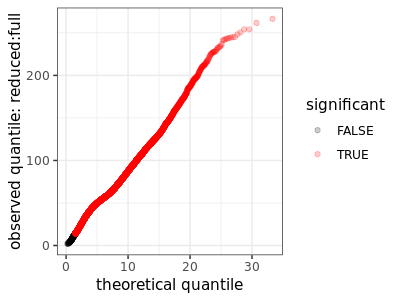

In [174]:
options(repr.plot.width = 4, repr.plot.height = 3, repr.plot.res = 100)
plot_qq(so_8, test = 'reduced:full', test_type = 'lrt', sig_level = 0.05)

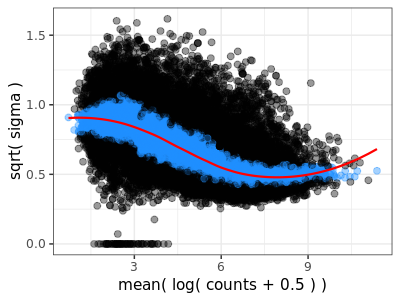

In [175]:
plot_mean_var(so_8, which_model="full")

# 9. Contrast: flower vs anther

In [337]:
# here filter to flower tissues only
is_flower <- b_meta %>% filter(gm == "wt") %>%
                        filter(high_level_tissue == "inflorescence") %>% select(ID, instrument, library, dataset, intermediate_tissue, zadok_scale) 
# here we select samples that are anther/stamen tissue
is_anther_yes <- is_flower %>% filter(intermediate_tissue == "anther" | intermediate_tissue == "stamen" | intermediate_tissue == "meiocyte") %>% 
                                              add_column(is_anther = "yes") %>% 
                                              select(ID, instrument, library, dataset, is_anther)
# here we select samples that are not anther/stamen, but are flower
is_anther_no <- is_flower %>% filter(intermediate_tissue != "anther" & intermediate_tissue != "stamen" & intermediate_tissue != "meiocyte") %>% 
                                              add_column(is_anther = "no") %>% 
                                              select(ID, instrument, library, dataset, is_anther)
# here we join tables of anther or not into one table
b_9 <- bind_rows(is_anther_yes, is_anther_no)
b_9$ID <- as.factor(b_9$ID)
b_9$dataset <- as.factor(b_9$dataset)
b_9$is_anther <- as.factor(b_9$is_anther)
b_9$instrument <- as.factor(b_9$instrument)
b_9$library <- as.factor(b_9$library)
# inspect ratios
glimpse(is_flower)
glimpse(is_anther_yes)
glimpse(is_anther_no)
# inspect full dataset
glimpse(b_9)
tail(b_9, 3)

Rows: 91
Columns: 6
$ ID                  <chr> "ERR1248084", "ERR1248085", "ERR1248086", "ERR124…
$ instrument          <chr> "Illumina HiSeq 2000", "Illumina HiSeq 2000", "Il…
$ library             <chr> "paired", "paired", "paired", "paired", "paired",…
$ dataset             <chr> "drought", "drought", "drought", "drought", "drou…
$ intermediate_tissue <chr> "spike", "spike", "spike", "spike", "spike", "spi…
$ zadok_scale         <int> 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 3…
Rows: 21
Columns: 5
$ ID         <chr> "SRR9889989", "SRR9889990", "SRR9889991", "SRR9889992", "S…
$ instrument <chr> "Illumina NextSeq 550", "Illumina NextSeq 550", "Illumina …
$ library    <chr> "paired", "paired", "paired", "paired", "paired", "paired"…
$ dataset    <chr> "meiosis", "meiosis", "meiosis", "meiosis", "meiosis", "me…
$ is_anther  <chr> "yes", "yes", "yes", "yes", "yes", "yes", "yes", "yes", "y…
Rows: 70
Columns: 5
$ ID         <chr> "ERR1248084", "ERR1248085", "ERR1248086", "ERR124808

,ID,instrument,library,dataset,is_anther
,<fct>,<fct>,<fct>,<fct>,<fct>
89,ERR515192,Illumina HiSeq 2000,paired,laxatum_mutant,no
90,ERR515193,Illumina HiSeq 2000,paired,laxatum_mutant,no
91,ERR515194,Illumina HiSeq 2000,paired,laxatum_mutant,no


In [338]:
setwd("/nfs/pgsb/projects/comparative_triticeae/phenotype/flower_development/refsets/hordeum/04_Kallisto_allreads_symlinked/")
files <- file.path("..", "04_Kallisto_allreads_symlinked", b_9$ID, "abundance.h5")
names(files) <- paste0(b_9$ID)
head(files)
all(file.exists(files))

SRR9889989 
"../04_Kallisto_allreads_symlinked/SRR9889989/abundance.h5" 
                                                 SRR9889990 
"../04_Kallisto_allreads_symlinked/SRR9889990/abundance.h5" 
                                                 SRR9889991 
"../04_Kallisto_allreads_symlinked/SRR9889991/abundance.h5" 
                                                 SRR9889992 
"../04_Kallisto_allreads_symlinked/SRR9889992/abundance.h5" 
                                                 SRR9889993 
"../04_Kallisto_allreads_symlinked/SRR9889993/abundance.h5" 
                                                 SRR9889994 
"../04_Kallisto_allreads_symlinked/SRR9889994/abundance.h5"

[1] TRUE

In [339]:
s2c_9 <- mutate(b_9, path = files, sample = ID)
head(s2c_9, 3)

,ID,instrument,library,dataset,is_anther,path,sample
,<fct>,<fct>,<fct>,<fct>,<fct>,<chr>,<fct>
1,SRR9889989,Illumina NextSeq 550,paired,meiosis,yes,../04_Kallisto_allreads_symlinked/SRR9889989/abundance.h5,SRR9889989
2,SRR9889990,Illumina NextSeq 550,paired,meiosis,yes,../04_Kallisto_allreads_symlinked/SRR9889990/abundance.h5,SRR9889990
3,SRR9889991,Illumina NextSeq 550,paired,meiosis,yes,../04_Kallisto_allreads_symlinked/SRR9889991/abundance.h5,SRR9889991


In [340]:
# construct the sleuth-object
so_9 <- sleuth_prep(sample_to_covariates = s2c_9, 
                  target_mapping = m,
                  extra_bootstrap_summary = TRUE,
                 aggregation_column="gene",
                  gene_mode = TRUE,
                 num_cores=1)

'gene_mode' is TRUE. Sleuth will do counts aggregation at the gene level for downstream normalization, transformation, and modeling steps, as well as for plotting and results.
reading in kallisto results
dropping unused factor levels
...........................................................................................
normalizing est_counts
21153 targets passed the filter
normalizing tpm
merging in metadata
aggregating by column: gene
21153 genes passed the filter
summarizing bootstraps
.................................................
..........................................


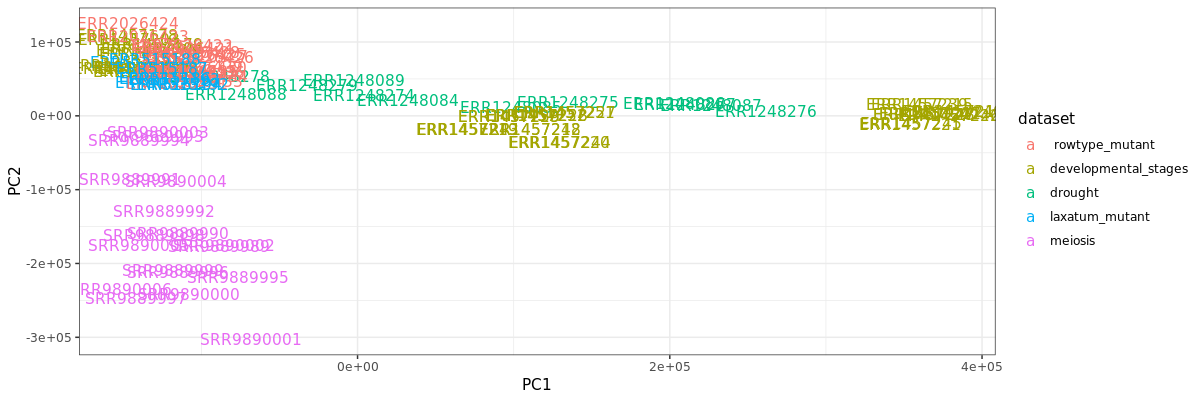

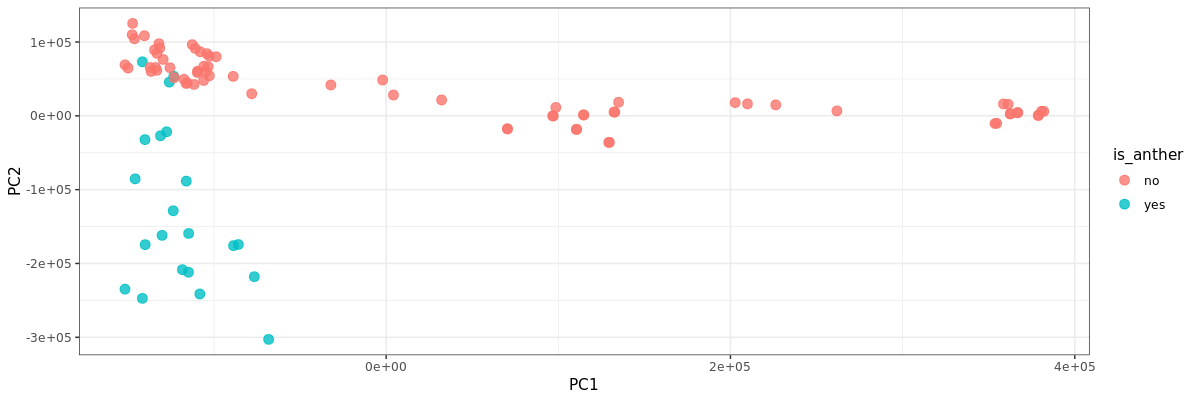

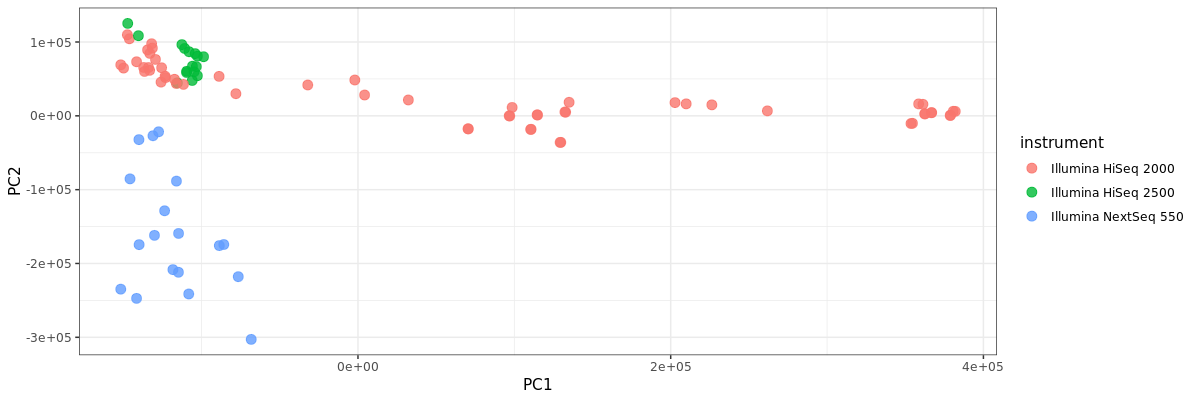

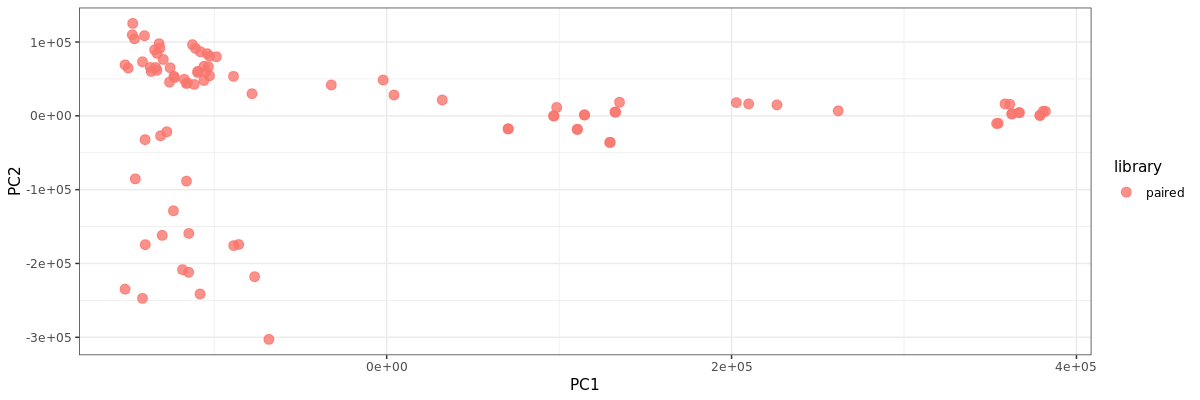

In [341]:
# check for pca
options(repr.plot.width = 12, repr.plot.height = 4, repr.plot.res = 100)
plot_pca(so_9, color_by = 'dataset',text_labels = TRUE,units='scaled_reads_per_base')
plot_pca(so_9, color_by = 'is_anther',text_labels = FALSE,units='scaled_reads_per_base')
plot_pca(so_9, color_by = 'instrument',text_labels = FALSE,units='scaled_reads_per_base')
plot_pca(so_9, color_by = 'library',text_labels = FALSE,units='scaled_reads_per_base')
# two main outliers from developmental stages dataset are rachis samples
# ERR1457171
# ERR1457170
# after excluding them the next new outlier ERR1457196 is a rachis sample from dataset as well

In [342]:
# create models
so_9 <- sleuth_fit(so_9, ~dataset + is_anther, 'full')
so_9 <- sleuth_fit(so_9, ~dataset, 'reduced')

fitting measurement error models
shrinkage estimation
3 NA values were found during variance shrinkage estimation due to mean observation values outside of the range used for the LOESS fit.
The LOESS fit will be repeated using exact computation of the fitted surface to extrapolate the missing values.
These are the target ids with NA values: Horvu_MOREX_3H01G244900, Horvu_MOREX_3H01G622000, Horvu_MOREX_6H01G048800
computing variance of betas
fitting measurement error models
shrinkage estimation
3 NA values were found during variance shrinkage estimation due to mean observation values outside of the range used for the LOESS fit.
The LOESS fit will be repeated using exact computation of the fitted surface to extrapolate the missing values.
These are the target ids with NA values: Horvu_MOREX_3H01G244900, Horvu_MOREX_3H01G622000, Horvu_MOREX_6H01G048800
computing variance of betas


In [343]:
# perform DGE tests
so_9 <- sleuth_lrt(so_9, 'reduced', 'full')
so_9 <- sleuth_wt(so_9, 'is_antheryes', which_model = "full")

In [344]:
models(so_9)

[  full  ]
formula:  ~dataset + is_anther 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)
 	datasetdevelopmental_stages
 	datasetdrought
 	datasetlaxatum_mutant
 	datasetmeiosis
 	is_antheryes
[  reduced  ]
formula:  ~dataset 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)
 	datasetdevelopmental_stages
 	datasetdrought
 	datasetlaxatum_mutant
 	datasetmeiosis


In [345]:
# exctract and inspect results of wald-test
so_wt9 <- sleuth_results(so_9,'is_antheryes','wt',which_model="full" ,show_all = FALSE,rename_cols=FALSE)
so_wt_sig9 <- filter(so_wt9, qval < 0.05)
nrow(so_wt_sig9)
table(so_wt_sig9$b>0)

[1] 21


TRUE 
  21 

In [346]:
# extract and inspect results of lrt
so_lrt9 <- sleuth_results(so_9, 'reduced:full', test_type = 'lrt',show_all=TRUE)
# join two tables into one
so_all9 <- na.omit(merge(so_lrt9, so_wt9, by = "target_id", suffixes = c(".lrt", ".wt")))
head(so_all9, 3)

,target_id,pval.lrt,qval.lrt,test_stat,rss,degrees_free,mean_obs.lrt,var_obs.lrt,tech_var,sigma_sq.lrt,⋯,pval.wt,qval.wt,b,se_b,mean_obs.wt,var_obs.wt,sigma_q_sq,sigma_sq.wt,smooth_sigma_sq.wt,smooth_sigma_sq_pmax
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Horvu_MOREX_1H01G000100,0.4148840,1,0.6647614330,8.512766,1,7.187480,0.3116839,0.000696578,0.09828907,⋯,0.4082936,1,-0.18429951,0.2228800,7.187480,0.3116839,0.000696578,0.0986544,0.0978386,0.0986544
2,Horvu_MOREX_1H01G000300,0.9819394,1,0.0005124589,10.417064,1,5.712407,0.1398521,0.004020681,0.11710797,⋯,0.6458777,1,-0.13552686,0.2949465,5.712407,0.1398521,0.004020681,0.1181008,0.1699662,0.1699662
3,Horvu_MOREX_1H01G000400,1.0000000,1,-0.0341104537,11.334702,1,6.811514,0.2355813,0.001367590,0.13043128,⋯,0.8665441,1,-0.04338568,0.2581716,6.811514,0.2355813,0.001367590,0.1319376,0.1064775,0.1319376


In [347]:
# inspect sig genes
table(so_all9$qval.lrt<0.05)
table(so_all9$qval.wt<0.05)
table(so_all9$qval.lrt<0.05,so_all9$qval.wt<0.05)


FALSE  TRUE 
21132    21 


FALSE  TRUE 
21132    21 

       
        FALSE  TRUE
  FALSE 21132     0
  TRUE      0    21

In [348]:
table9 <- select(so_all9, "target_id","test_stat","b","qval.lrt","qval.wt",)
sig9_1 <- filter(table9, qval.lrt <= 0.1)
glimpse(sig9_1)
sig9_05 <- filter(table9, qval.lrt <= 0.05)
glimpse(sig9_05)
sig9_01 <- filter(table9, qval.lrt <= 0.01)
glimpse(sig9_01)
# look at table and few of 0.05
head(sig9_05, 5)

Rows: 25
Columns: 5
$ target_id <chr> "Horvu_MOREX_1H01G176900", "Horvu_MOREX_1H01G538900", "Horv…
$ test_stat <dbl> 22.15397, 15.11612, 28.17293, 20.19466, 27.13684, 16.70111,…
$ b         <dbl> 1.0296188, 0.9776928, 1.8559548, 0.9776588, 1.4495884, 1.70…
$ qval.lrt  <dbl> 4.838954e-03, 8.553970e-02, 6.904928e-04, 1.056866e-02, 6.9…
$ qval.wt   <dbl> 5.207729e-03, 9.072863e-02, 1.890196e-04, 9.819817e-03, 2.3…
Rows: 21
Columns: 5
$ target_id <chr> "Horvu_MOREX_1H01G176900", "Horvu_MOREX_1H01G562100", "Horv…
$ test_stat <dbl> 22.15397, 28.17293, 20.19466, 27.13684, 16.70111, 17.67541,…
$ b         <dbl> 1.0296188, 1.8559548, 0.9776588, 1.4495884, 1.7065444, 3.77…
$ qval.lrt  <dbl> 4.838954e-03, 6.904928e-04, 1.056866e-02, 6.904928e-04, 4.4…
$ qval.wt   <dbl> 5.207729e-03, 1.890196e-04, 9.819817e-03, 2.324694e-04, 3.3…
Rows: 12
Columns: 5
$ target_id <chr> "Horvu_MOREX_1H01G176900", "Horvu_MOREX_1H01G562100", "Horv…
$ test_stat <dbl> 22.15397, 28.17293, 27.13684, 31.38093, 24.84378, 37.

,target_id,test_stat,b,qval.lrt,qval.wt
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,Horvu_MOREX_1H01G176900,22.15397,1.0296188,0.0048389544,0.0052077291
2,Horvu_MOREX_1H01G562100,28.17293,1.8559548,0.0006904928,0.0001890196
3,Horvu_MOREX_2H01G051300,20.19466,0.9776588,0.0105686564,0.0098198173
4,Horvu_MOREX_2H01G562000,27.13684,1.4495884,0.0006904928,0.0002324694
5,Horvu_MOREX_2H01G582000,16.70111,1.7065444,0.0440741044,0.0339702997


In [349]:
# save 3 sets of DEGsin .csv
setwd("/nfs/pgsb/projects/comparative_triticeae/phenotype/flower_development/refsets/hordeum/")
write.table(sig9_1, file = "deg9_signif0_1.csv", sep = ",", col.names = TRUE)
write.table(sig9_05, file = "deg9_signif0_05.csv", sep = ",", col.names = TRUE)
write.table(sig9_01, file = "deg9_signif0_01.csv", sep = ",", col.names = TRUE)

In [350]:
sleuth_live_settings(test_type = "lrt")
sleuth_live(so_anther2, settings = sleuth_live_settings())
# in order to display: open new terminal tab and type: `ssh -L localhost:42427:localhost:42427 vanda.marosi@bee`
# number after localhost has to match the last number written in the output
# after this, copy and enter http site address 

$test_type
[1] "lrt"

ERROR: Error in is(obj, "sleuth"): object 'so_anther2' not found


In [351]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /home/vanda.marosi/anaconda3/envs/r/lib/libopenblasp-r0.3.9.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=de_DE.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=de_DE.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=de_DE.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=de_DE.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] shiny_1.3.2         pheatmap_1.0.12     vsn_3.54.0         
 [4] Biobase_2.46.0      BiocGenerics_0.32.0 RColorBrewer_1.1-2 
 [7] cowplot_1.0.0       forcats_0.5.0       stringr_1.4.0      
[10] dplyr_0.8.5         purrr_0.3.4         readr_1.3.1        
[13] tidyr_1.0.2       